In [17]:
test_semantic_model_url = '/tmp/llm/semantic_model.txt' 
questions_url           = '/tmp/llm/questions.json'
SF                      = 0.1
max_attempts            = 3
TIMEOUT_SECONDS         = 60 
output_dir              = "/tmp/llm"
model0                  = "o3-mini"
enable_feedback_loop    = True

# Setup

In [18]:
import requests
import json
import duckdb
import pathlib
import time
import re
from   openai import AzureOpenAI, OpenAIError
import datetime
import os
import threading
import pandas as pd


In [19]:
if SF <1 :
 schema = f"DS{str(SF).replace('.', '_')}"
else :
 schema = f'DS{SF:02d}'
os.makedirs(output_dir, exist_ok=True)
db_path = output_dir +"/"+ schema +".duckdb"
if not pathlib.Path(db_path).exists():
    con = duckdb.connect(db_path)
    con.sql("SET memory_limit = '14GB' ")
    con.sql(f"CALL dsdgen(sf={SF})")
    con.close()
con = duckdb.connect()
con.sql(f""" attach '{db_path}' as ds(read_only) ; use ds """)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [20]:
def get_ai_response(user_message, LLM, provider, api_key=None, azure_endpoint=None, azure_api_version=None):
    system_prompt = ""
    try:
        github_response = requests.get(test_semantic_model_url)
        github_response.raise_for_status()
        system_prompt = github_response.text.strip()
    except requests.RequestException as e:
        try:
            with open(test_semantic_model_url, 'r', encoding='utf-8') as f:
                system_prompt = f.read().strip()
        except Exception as e2:
            print(f"Error loading system prompt from local path: {e2}")
            return f"Error fetching system prompt: {e2}"

    generated_text = None
    data = None

    if provider == "ollama":
        # Try Ollama first (default port 11434), then fall back to LM Studio (port 1234)
        ollama_urls = [
            'http://127.0.0.1:11434/v1/chat/completions',  # Standard Ollama OpenAI API
            'http://127.0.0.1:1234/v1/chat/completions'    # LM Studio fallback
        ]
        
        headers = {'Content-Type': 'application/json'}
        payload = {
            'model': LLM,
            'messages': [
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_message}
            ],
            'stream': False
        }
        
        last_error = None
        for url in ollama_urls:
            try:
                response = requests.post(url, headers=headers, json=payload, timeout=TIMEOUT_SECONDS)
                response.raise_for_status()
                data = response.json()
                generated_text = data.get('choices', [{}])[0].get('message', {}).get('content', '')
                if generated_text:
                    generated_text = generated_text.replace("<think>", "").replace("</think>", "")
                break  # Success, exit the loop
            except requests.RequestException as e:
                last_error = e
                continue  # Try next URL
        else:
            # If we get here, all URLs failed
            return f"Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: {last_error}"
        
        if not generated_text:
            return f"No content received from Ollama/LM Studio. Response data: {data}"

    elif provider == "azure_foundry":
        if not azure_endpoint or not azure_api_version or not api_key:
            return "Azure provider requires 'azure_endpoint', 'azure_api_version', and 'api_key' parameters."

        try:
            client = AzureOpenAI(
                api_version=azure_api_version,
                azure_endpoint=azure_endpoint,
                api_key=api_key,
            )

            response = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_message}
                ],
                model=LLM,
            )

            generated_text = response.choices[0].message.content

        except Exception as e:
            return f"An error occurred with Azure OpenAI: {e}"



    else:
        return f"Unsupported provider for this test setup: {provider}. Supported providers are 'ollama' (LM Studio), 'azure_foundry', and 'gemini'."

    if not isinstance(generated_text, str):
         print(f"Generated text is not a string (type: {type(generated_text)}). Cannot clean.")
         if generated_text is None:
              return "Could not retrieve generated text from provider response."
         else:
              return f"Received unexpected output type from {provider}: {type(generated_text)}. Value: {generated_text}"

    # Enhanced text cleaning to extract SQL
    cleaned_text = generated_text
    
    # Simple approach: extract content after final channel message
    # Look for the pattern: <|channel|>final<|message|> and take everything after it
    final_message_match = re.search(r'<\|channel\|>final<\|message\|>(.*?)(?:<\|end\|>|$)', cleaned_text, re.DOTALL)
    if final_message_match:
        cleaned_text = final_message_match.group(1).strip()
    else:
        # Fallback: look for any final message pattern
        message_matches = re.findall(r'<\|message\|>(.*?)(?:<\|end\|>|$)', cleaned_text, re.DOTALL)
        if message_matches:
            cleaned_text = message_matches[-1].strip()  # Take the last message
        else:
            # Remove all chat template tokens if no specific pattern found
            cleaned_text = re.sub(r'<\|[^|]*\|>', '', cleaned_text).strip()
    
    # Remove any remaining template tokens
    cleaned_text = re.sub(r'<\|[^|]*\|>', '', cleaned_text).strip()
    
    # Remove thinking tags if present
    cleaned_text = re.sub(r'<think>.*?</think>', '', cleaned_text, flags=re.DOTALL | re.IGNORECASE).strip()
    
    # Clean up code blocks if present
    sql_in_blocks = re.findall(r'```(?:sql|duckdb)?\s*([\s\S]*?)\s*```', cleaned_text, flags=re.IGNORECASE)
    if sql_in_blocks:
        cleaned_text = sql_in_blocks[-1].strip()
    
    # Final cleanup
    cleaned_text = cleaned_text.replace("```sql", "").replace("```duckdb", "").replace("```", "").strip()
    
    # Simple extraction: return everything after the first '--' comment
    # This handles LM Studio's new format that puts SQL after explanatory text and comments
    double_dash_pos = cleaned_text.find('--')
    if double_dash_pos != -1:
        # Find the end of the comment line (newline after --)
        comment_end = cleaned_text.find('\n', double_dash_pos)
        if comment_end != -1:
            # Return everything after the comment line
            sql_after_comment = cleaned_text[comment_end + 1:].strip()
            if sql_after_comment:
                return sql_after_comment
    
    return cleaned_text

def get_feedback_response(original_question, sql_query, query_results, LLM, provider, api_key=None, azure_endpoint=None, azure_api_version=None):
    """
    Ask LLM to review its SQL query results and decide if they need modification
    """
    # Convert results to a readable format for LLM review with quality analysis
    if isinstance(query_results, pd.DataFrame):
        if len(query_results) > 10:
            # Show first 10 rows plus summary for large results
            results_preview = f"Results (showing first 10 of {len(query_results)} rows):\n{query_results.head(10).to_string()}\n\nTotal rows: {len(query_results)}"
        else:
            results_preview = f"Results ({len(query_results)} rows):\n{query_results.to_string()}"
        
        # Add quality analysis to help LLM detect issues
        quality_analysis = []
        
        # Check for duplicates in single-column results
        if len(query_results.columns) == 1:
            col_name = query_results.columns[0]
            total_rows = len(query_results)
            unique_rows = query_results[col_name].nunique()
            if total_rows > unique_rows:
                duplicate_count = total_rows - unique_rows
                quality_analysis.append(f"⚠️ POTENTIAL ISSUE: Single column '{col_name}' has {duplicate_count} duplicate values out of {total_rows} total rows. For 'list categories' type questions, duplicates are usually wrong.")
        
        # Check for suspicious patterns in category-like questions
        if "categor" in original_question.lower() or "list" in original_question.lower():
            if len(query_results.columns) == 1:
                col_name = query_results.columns[0]
                if query_results[col_name].nunique() < len(query_results):
                    quality_analysis.append(f"⚠️ POTENTIAL ISSUE: This appears to be a 'list categories' question but your result contains duplicate category names. Consider using DISTINCT.")
        
        # Check for ordering when requested
        if "order" in original_question.lower() or "sort" in original_question.lower():
            if "alphabetical" in original_question.lower() or "alphabetically" in original_question.lower():
                quality_analysis.append(f"ℹ️ REMINDER: Question asks for alphabetical ordering. Verify your ORDER BY clause is correct.")
        
        if quality_analysis:
            quality_section = "\n\nQUALITY ANALYSIS:\n" + "\n".join(quality_analysis)
        else:
            quality_section = ""
            
    else:
        results_preview = "No results returned (empty or error)"
        quality_section = ""
    
    feedback_prompt = f"""
You previously generated this SQL query for the following question:

ORIGINAL QUESTION: {original_question}

YOUR SQL QUERY:
{sql_query}

QUERY RESULTS:
{results_preview}{quality_section}

Please review your SQL query and its results carefully. Does the output correctly answer the original question? 

Pay special attention to:
- Are there duplicate rows when the question asks for distinct items/categories?
- Is the data properly ordered as requested (alphabetically, numerically, etc.)?
- Does the result make logical sense for the question asked?
- Are you selecting the right columns and using appropriate filtering?

CRITICAL: If you see duplicate values in a single column when the question asks for "different" or "various" items, this is almost always WRONG. Use DISTINCT to get unique values only.

If the results look correct and fully answer the question, respond with: "RESULTS_CORRECT"

If the results need improvement (wrong data, missing information, incorrect calculations, duplicates, wrong ordering, etc.), provide a revised SQL query that better answers the question. 

IMPORTANT: Return ONLY the SQL query without any explanation, markdown formatting, or additional text. Just the pure SQL statement.

Your response:"""

    try:
        system_prompt = ""
        try:
            github_response = requests.get(test_semantic_model_url)
            github_response.raise_for_status()
            system_prompt = github_response.text.strip()
        except requests.RequestException as e:
            try:
                with open(test_semantic_model_url, 'r', encoding='utf-8') as f:
                    system_prompt = f.read().strip()
            except Exception as e2:
                print(f"Error loading system prompt from local path: {e2}")
                return f"Error fetching system prompt: {e2}"

        generated_text = None
        data = None

        if provider == "ollama":
            # Try Ollama first (default port 11434), then fall back to LM Studio (port 1234)
            ollama_urls = [
                'http://127.0.0.1:11434/v1/chat/completions',  # Standard Ollama OpenAI API
                'http://127.0.0.1:1234/v1/chat/completions'    # LM Studio fallback
            ]
            
            headers = {'Content-Type': 'application/json'}
            payload = {
                'model': LLM,
                'messages': [
                    {'role': 'system', 'content': system_prompt},
                    {'role': 'user', 'content': feedback_prompt}
                ],
                'stream': False
            }
            
            last_error = None
            for url in ollama_urls:
                try:
                    response = requests.post(url, headers=headers, json=payload, timeout=TIMEOUT_SECONDS)
                    response.raise_for_status()
                    data = response.json()
                    generated_text = data.get('choices', [{}])[0].get('message', {}).get('content', '')
                    if generated_text:
                        generated_text = generated_text.replace("<think>", "").replace("</think>", "")
                    break  # Success, exit the loop
                except requests.RequestException as e:
                    last_error = e
                    continue  # Try next URL
            else:
                # If we get here, all URLs failed
                return f"Error connecting to Ollama/LM Studio for feedback. Tried ports 11434 and 1234. Last error: {last_error}"
            
            if not generated_text:
                return f"No content received from Ollama/LM Studio feedback. Response data: {data}"

        elif provider == "azure_foundry":
            if not azure_endpoint or not azure_api_version or not api_key:
                return "Azure provider requires 'azure_endpoint', 'azure_api_version', and 'api_key' parameters."

            try:
                client = AzureOpenAI(
                    api_version=azure_api_version,
                    azure_endpoint=azure_endpoint,
                    api_key=api_key,
                )

                response = client.chat.completions.create(
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": feedback_prompt}
                    ],
                    model=LLM,
                )

                generated_text = response.choices[0].message.content

            except Exception as e:
                return f"An error occurred with Azure OpenAI: {e}"

        else:
            return f"Unsupported provider for feedback: {provider}. Supported providers are 'ollama' (LM Studio) and 'azure_foundry'."

        if not isinstance(generated_text, str):
            print(f"Generated text is not a string (type: {type(generated_text)}). Cannot clean.")
            if generated_text is None:
                return "Could not retrieve generated text from provider response."
            else:
                return f"Received unexpected output type from {provider}: {type(generated_text)}. Value: {generated_text}"

        # Clean the feedback response
        cleaned_text = generated_text
        
        # Remove template tokens
        cleaned_text = re.sub(r'<\|[^|]*\|>', '', cleaned_text).strip()
        
        # Remove thinking tags if present
        cleaned_text = re.sub(r'<think>.*?</think>', '', cleaned_text, flags=re.DOTALL | re.IGNORECASE).strip()
        
        # Clean up code blocks if present
        sql_in_blocks = re.findall(r'```(?:sql|duckdb)?\s*([\s\S]*?)\s*```', cleaned_text, flags=re.IGNORECASE)
        if sql_in_blocks:
            cleaned_text = sql_in_blocks[-1].strip()
        
        # Final cleanup
        cleaned_text = cleaned_text.replace("```sql", "").replace("```duckdb", "").replace("```", "").strip()
        
        return cleaned_text

    except Exception as e:
        return f"Error in feedback loop: {e}"

In [21]:
def execute_sql_with_retry(query, test_model, provider, api_key, azure_endpoint, azure_api_version):
    attempt = 1
    current_query = query.strip()

    while attempt <= max_attempts:
        con.sql("SET enable_progress_bar_print = false")
        con.sql("SET progress_bar_time = 0")

        result_container = {"result": None, "error": None}

        def query_thread():
            try:
                result_container["result"] = con.execute(current_query).fetchdf()
            except duckdb.InterruptException:
                result_container["error"] = f"Query interrupted after timeout of {TIMEOUT_SECONDS} seconds."
            except Exception as e:
                result_container["error"] = str(e)

        thread = threading.Thread(target=query_thread)
        thread.start()

        start_time = time.time()
        while thread.is_alive():
            elapsed = time.time() - start_time
            if elapsed > TIMEOUT_SECONDS:
                con.interrupt()
                thread.join()
                return f"Query execution timed out after {TIMEOUT_SECONDS} seconds.", attempt, "query runs forever"
            time.sleep(0.1)

        if result_container["error"]:
            error_message = result_container["error"].lower()
            if "syntax" not in error_message and "parser" not in error_message and "binder" not in error_message:
                return f"Non-syntax error: {result_container['error']}", attempt, current_query

            print(current_query)
            print(f"Attempt {attempt}/{max_attempts} failed with syntax error: {result_container['error']}")

            if attempt == max_attempts:
                return f"Max attempts reached. Last error: {result_container['error']}", attempt, current_query

            message = (
                f"The following SQL query has a syntax error: '{current_query}'.\n"
                f"Error message: {result_container['error']}\n"
                f"Please provide the corrected SQL query. Return only the corrected query without explanation."
            )

            corrected_query = get_ai_response(message, test_model, provider, api_key, azure_endpoint, azure_api_version)

            if corrected_query.startswith("Error"):
                return f"Failed to get corrected query : {corrected_query}", attempt, current_query

            current_query = corrected_query.strip()
            attempt += 1
        else:
            return result_container["result"], attempt, current_query

    return "Unexpected error or loop termination", attempt, current_query


In [22]:
def ask_question(questions, test_model,provider,api_key=None, azure_endpoint=None, azure_api_version=None):
    results_data = [] 
    for i, x in enumerate(questions):
        print(f"Question {i+1}: {x}") # Keep or remove print as needed
        start_time = time.time()
        sql_query_or_error = get_ai_response(x, test_model, provider, api_key, azure_endpoint, azure_api_version)
        # print(f"Initial SQL: {sql_query_or_error}") # SQL output hidden
        query_result_data_json = [] # Initialize as an empty list for JSON result
        attempts_count = None
        error_details = None # Initialize error_details
        feedback_iterations = 0  # Track feedback loop iterations
        final_sql_query = sql_query_or_error  # Track the final query used
        
        if sql_query_or_error is None or sql_query_or_error.startswith("Error"):
            # If get_ai_response returned an error or None, store the error string
            error_message = sql_query_or_error if sql_query_or_error is not None else "AI response was None"
            error_details = f"AI Error: {error_message}" # Store error details
            result_row_count = 0 # Result count is 0 on error
        else:
            # Execute the initial query
            result_from_execution, attempts_count, query_returned = execute_sql_with_retry(sql_query_or_error, test_model, provider, api_key, azure_endpoint, azure_api_version)
            final_sql_query = query_returned  # Update final query
            
            is_successful = isinstance(result_from_execution, pd.DataFrame)
            
            # If successful and feedback loop is enabled, ask LLM to review results
            if is_successful and enable_feedback_loop and feedback_iterations < max_attempts:
                # print(f"Initial execution successful. Starting feedback loop...") # Feedback output hidden
                
                current_query = query_returned
                current_result = result_from_execution
                
                while feedback_iterations < max_attempts:
                    # print(f"Feedback iteration {feedback_iterations + 1}/{max_attempts}") # Feedback output hidden
                    
                    # Get LLM feedback on current results
                    feedback_response = get_feedback_response(
                        x, current_query, current_result, 
                        test_model, provider, api_key, azure_endpoint, azure_api_version
                    )
                    
                    # print(f"LLM Feedback: {feedback_response[:100]}...")  # Feedback output hidden
                    
                    # Check if LLM is satisfied with results
                    if "RESULTS_CORRECT" in feedback_response.upper():
                        # print("✅ LLM confirmed results are correct") # Feedback output hidden
                        break
                    elif feedback_response.startswith("Error"):
                        # print(f"❌ Error in feedback loop: {feedback_response}") # Feedback output hidden
                        break
                    else:
                        # LLM provided a revised query
                        # print("🔄 LLM provided revised query, testing...") # Feedback output hidden
                        
                        # Try the revised query
                        revised_result, revised_attempts, revised_query = execute_sql_with_retry(
                            feedback_response, test_model, provider, api_key, azure_endpoint, azure_api_version
                        )
                        
                        if isinstance(revised_result, pd.DataFrame):
                            # print("✅ Revised query executed successfully") # Feedback output hidden
                            current_query = revised_query
                            current_result = revised_result
                            final_sql_query = revised_query  # Update final query
                            attempts_count = (attempts_count or 0) + (revised_attempts or 0)  # Add attempts
                        else:
                            # print(f"❌ Revised query failed: {revised_result}") # Feedback output hidden
                            break
                    
                    feedback_iterations += 1
                
                # Use the final result from feedback loop
                result_from_execution = current_result
                
                # print(f"Feedback loop completed after {feedback_iterations} iterations") # Feedback output hidden

            display(result_from_execution)
            is_successful = isinstance(result_from_execution, pd.DataFrame)

            if is_successful:
                # print("Execution: SUCCESS") # Execution status hidden
                query_result_data_json = result_from_execution.to_dict('records')
                error_details = None # No error details on success
                result_row_count = len(result_from_execution) # Calculate row count
            else:
                print("Execution: FAILED") # Keep error status visible
                #query_result_data_json remains empty []
                error_details = f"Execution Error: {result_from_execution}" # Store error details
                result_row_count = 0 # Result count is 0 on failure


        end_time = time.time()
        duration = round(end_time - start_time, 2)
        # print(f"\nExecution Time: {duration:.2f} seconds") # Timing hidden
        print(f" ############################### ") # Keep separator
        results_data.append({
            "model" : test_model,
            "SF" : SF,
            "timestamp": timestamp,
            "nbr": i + 1,
            "question": x,
            "duration_s": duration, 
            "sql_query": final_sql_query,  # Use the final query (potentially revised)
            "attempts": attempts_count,
            "feedback_iterations": feedback_iterations,  # Track feedback iterations
            "result": query_result_data_json, 
            "result_count": result_row_count, 
            "error_details": error_details 
        })
    log_dir = output_dir +"/log"
    os.makedirs(log_dir, exist_ok=True)
    sanitized_model = re.sub(r'[\\/*?:"<>|]', '_', test_model)
    output_filename = f"{timestamp}_{sanitized_model}.json"
    output_path = os.path.join(log_dir, output_filename)
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results_data, f, indent=4)
            f.flush()
            os.fsync(f.fileno())
        return f"Successfully processed {len(questions)} questions. Results saved to {output_path}"
    except IOError as e:
        return f"Error saving results to {output_path}: {e}"
    except Exception as e:
        return f"An unexpected error occurred during file saving: {e}"

In [23]:
def query_llm_with_results(question, model, provider, api_key=None, azure_endpoint=None, azure_api_version=None):
    """
    Unified function: LLM generates SQL and returns both query and results/error
    
    Returns:
        dict with keys: 'question', 'sql_query', 'result', 'error', 'attempts', 'feedback_iterations', 'duration'
    """
    start_time = time.time()
    
    # Get initial SQL from LLM
    sql_query = get_ai_response(question, model, provider, api_key, azure_endpoint, azure_api_version)
    
    if sql_query is None or sql_query.startswith("Error"):
        return {
            'question': question,
            'sql_query': sql_query,
            'result': None,
            'error': f"AI Error: {sql_query}",
            'attempts': 0,
            'feedback_iterations': 0,
            'duration': round(time.time() - start_time, 2)
        }
    
    # Execute initial query with retries
    result, attempts, final_query = execute_sql_with_retry(sql_query, model, provider, api_key, azure_endpoint, azure_api_version)
    feedback_iterations = 0
    
    # If successful and feedback enabled, try to improve
    if isinstance(result, pd.DataFrame) and enable_feedback_loop:
        current_query = final_query
        current_result = result
        
        while feedback_iterations < max_attempts:
            # Get LLM feedback
            feedback = get_feedback_response(question, current_query, current_result, model, provider, api_key, azure_endpoint, azure_api_version)
            
            if "RESULTS_CORRECT" in feedback.upper():
                break
            elif feedback.startswith("Error"):
                break
            else:
                # Try revised query
                revised_result, revised_attempts, revised_query = execute_sql_with_retry(feedback, model, provider, api_key, azure_endpoint, azure_api_version)
                
                if isinstance(revised_result, pd.DataFrame):
                    current_query = revised_query
                    current_result = revised_result
                    final_query = revised_query
                    result = revised_result
                    attempts += revised_attempts
                else:
                    break
            
            feedback_iterations += 1
    
    return {
        'question': question,
        'sql_query': final_query,
        'result': result if isinstance(result, pd.DataFrame) else None,
        'error': result if not isinstance(result, pd.DataFrame) else None,
        'attempts': attempts,
        'feedback_iterations': feedback_iterations,
        'duration': round(time.time() - start_time, 2)
    }

In [24]:
# Example usage of the unified LLM query function
def demo_unified_query():
    """
    Example of how to use the new unified function
    """
    question = "What are the top 5 customers by total order value?"
    
    # Single function call gets SQL and results
    result = query_llm_with_results(
        question=question,
        model=model1, 
        provider="ollama"
    )
    
    print(f"Question: {result['question']}")
    print(f"SQL Query: {result['sql_query']}")
    print(f"Attempts: {result['attempts']}")
    print(f"Feedback Iterations: {result['feedback_iterations']}")
    print(f"Duration: {result['duration']}s")
    
    if result['result'] is not None:
        print("✅ Success!")
        display(result['result'])
    else:
        print(f"❌ Error: {result['error']}")

# Uncomment to run the demo:
# demo_unified_query()

In [25]:
def display_side_by_side(nbr, model1, model2):
    print(f"question {nbr} : " + duckdb.sql(f" select question from results_filtered where nbr = {nbr}  ").fetchone()[0])
    try:
        sql_query1 = duckdb.sql(f""" select sql_query from results_filtered where nbr = {nbr} and model = '{model1}' """).fetchone()[0]
        sql_query2 = duckdb.sql(f""" select sql_query from results_filtered where nbr = {nbr} and model = '{model2}' """).fetchone()[0]
        df1 = con.sql(sql_query1).df()        
        df2 = con.sql(sql_query2).df() 
        side_by_side = pd.concat([df1, df2], axis=1, keys=[model1, model2])
        display(side_by_side)
        # Print the SQL queries clearly labeled
        print(f"{model1} SQL Query:")
        print("--------------------")
        print(sql_query1)
        print("\n") # Add a newline for separation

        print(f"{model2} SQL Query:")
        print("--------------------")
        print(sql_query2)
        print("\n") # Add a newline for separation
    except Exception as e:
        print(f"Error executing query for nbr {nbr}: {e}")

In [26]:
# get the questions from GitHub, if error try local path
try:
    response = requests.get(questions_url)
    response.raise_for_status()
    questions = json.loads(response.text)
    print("Successfully retrieved questions from GitHub.")
except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
    print(f"Error retrieving from GitHub: Trying local path...")
    try:
        with open(questions_url, 'r', encoding='utf-8') as f:
            questions = json.load(f)
        print("Successfully loaded questions from local path.")
    except Exception as e2:
        print(f"Error loading questions from local path: {e2}")
        questions = []

Error retrieving from GitHub: Trying local path...
Successfully loaded questions from local path.


In [27]:
# Test Ollama/LM Studio connection
def test_ollama_connection():
    """
    Test connection to Ollama or LM Studio and show which one is available
    """
    import requests
    import sys
    
    # Test endpoints in priority order
    endpoints = [
        ('Ollama', 'http://127.0.0.1:11434/v1/chat/completions'),
        ('LM Studio', 'http://127.0.0.1:1234/v1/chat/completions')
    ]
    
    print("🔍 Testing API connections...")
    
    for name, url in endpoints:
        try:
            # Simple test payload
            payload = {
                'model': 'test',
                'messages': [{'role': 'user', 'content': 'test'}],
                'stream': False
            }
            
            response = requests.post(url, json=payload, timeout=3)
            # Even if we get an error, if we can connect it means the service is running
            print(f"✅ {name} is running on {url}")
            return name.lower().replace(' ', '_'), url
            
        except requests.exceptions.ConnectionError:
            print(f"❌ {name} not available on {url}")
        except Exception as e:
            print(f"✅ {name} is running on {url} (got response: {type(e).__name__})")
            return name.lower().replace(' ', '_'), url
    
    print("⚠️ No API endpoints are available. Please start Ollama or LM Studio:")
    print("   • Ollama: Run 'ollama serve' (default port 11434)")
    print("   • LM Studio: Start server on port 1234")
    print("\n🛑 STOPPING EXECUTION - No API connection available!")
    print("   Please start an API server before running the tests.")
    
    # Stop notebook execution
    raise SystemExit("No API connection available. Execution stopped.")

# Test connection - script will stop here if no API is available
api_service, api_url = test_ollama_connection()
print(f"🚀 Proceeding with {api_service} at {api_url}")

🔍 Testing API connections...
❌ Ollama not available on http://127.0.0.1:11434/v1/chat/completions
❌ Ollama not available on http://127.0.0.1:11434/v1/chat/completions
✅ LM Studio is running on http://127.0.0.1:1234/v1/chat/completions (got response: ReadTimeout)
🚀 Proceeding with lm_studio at http://127.0.0.1:1234/v1/chat/completions
✅ LM Studio is running on http://127.0.0.1:1234/v1/chat/completions (got response: ReadTimeout)
🚀 Proceeding with lm_studio at http://127.0.0.1:1234/v1/chat/completions


# Run Tests

In [28]:
%%time
#ask_question(questions,"o3-mini","azure_foundry",os.getenv("o3_mini_key"), os.getenv("llm_endpoint"),"2025-01-01-preview" )
ask_question(questions,"smallthinker-21ba3b-instruct","ollama")

Question 1: What is the overall total sales revenue?
SELECT SUM(ss.ss_sales_price * ss.ss_quantity) as total_sales_revenue
FROM store_sales
WHERE ss.ss_customer_sk IS NOT NULL;
Attempt 1/3 failed with syntax error: Binder Error: Referenced table "ss" not found!
Candidate tables: "store_sales"

LINE 3: WHERE ss.ss_customer_sk IS NOT NULL;
              ^
SELECT SUM(ss.ss_sales_price * ss.ss_quantity) as total_sales_revenue
FROM store_sales
WHERE ss.ss_customer_sk IS NOT NULL;
Attempt 1/3 failed with syntax error: Binder Error: Referenced table "ss" not found!
Candidate tables: "store_sales"

LINE 3: WHERE ss.ss_customer_sk IS NOT NULL;
              ^


,total_sales_revenue
0,5.143009e+08


 ############################### 
Question 2: What is the total number of items sold across all transactions?


,total_items_sold
0,13939520.0


 ############################### 
Question 3: What is the total monetary value of all returned items?


,total_returned_value
0,26706800.77


 ############################### 
Question 4: List the names of all stores, order by store name.


,s_store_name
0,ought


 ############################### 
Question 5: What are the different item categories available? Order alphabetically by category name.


,i_category
0,Books
1,Children
2,Electronics
3,Home
4,Jewelry
5,Men
6,Music
7,Shoes
8,Sports
9,Women


 ############################### 
Question 6: Show total sales revenue for each year, ordered chronologically by year.


,d_year,total_sales_amt
0,1998,1.022972e+08
1,1999,9.937045e+07
2,2000,1.031840e+08
3,2001,1.021729e+08
4,2002,1.002891e+08
5,2003,8.737749e+05


 ############################### 
Question 7: Which store generated the most total sales revenue? show store and total sales (To ensure a deterministic result if there's a tie, you might order by revenue descending and then store name alphabetically).


,s_store_name,total_sales
0,ought,5.079412e+08


 ############################### 
Question 8: What is the total quantity of items sold, broken down by item brand? Order by quantity sold descending, and then by brand name alphabetically for ties.


,i_brand,total_quantity_sold
0,exportischolar #2,322219.0
1,exportischolar #2,322219.0
2,exportischolar #2,322219.0
3,exportischolar #2,322219.0
4,exportischolar #2,322219.0
...,...,...
1791,corpamalgamalg #17,2415.0
1792,exportibrand #9,2383.0
1793,univbrand #1,2371.0
1794,univamalgamalg #7,2211.0


 ############################### 
Question 9: Compare total sales from preferred customers versus non-preferred customers, ordered by total sales
ORDER BY total_sales DESC;
Attempt 1/3 failed with syntax error: Parser Error: syntax error at or near "ORDER"
ORDER BY total_sales DESC;
Attempt 1/3 failed with syntax error: Parser Error: syntax error at or near "ORDER"


,net_sales
0,4.875941e+08


 ############################### 
Question 10: What is the total return amount for each city where stores are located, ordered alphabetically by city name.
GROUP BY st.s_city
)
SELECT 
    COALESCE(st.s_city, 0) AS city,
    COALESCE(total_returns, 0) AS total_returns
FROM store_returns_agg
FULL OUTER JOIN store s ON st.s_city = s.s_city  -- Join through shared dimension 'store'
GROUP BY ALL
ORDER BY st.s_city;
Attempt 1/3 failed with syntax error: Parser Error: syntax error at or near "GROUP"
GROUP BY st.s_city
)
SELECT 
    COALESCE(st.s_city, 0) AS city,
    COALESCE(total_returns, 0) AS total_returns
FROM store_returns_agg
FULL OUTER JOIN store s ON st.s_city = s.s_city  -- Join through shared dimension 'store'
GROUP BY ALL
ORDER BY st.s_city;
Attempt 1/3 failed with syntax error: Parser Error: syntax error at or near "GROUP"
WITH store_returns_agg AS (
    SELECT 
        s.s_store_name,
        SUM(sr.sr_return_amt) AS total_returns
    FROM store_returns sr
    JOIN store s ON s

'Max attempts reached. Last error: Binder Error: Table "ss" does not have a column named "s_store_name"\n\nCandidate bindings: : "ss_store_sk"\n\nLINE 14:     GROUP BY ss.s_store_name\n                      ^'

Execution: FAILED
 ############################### 
Question 11: What is the net sales for each store name, order by net sales.


,store_name,net_sales
0,ought,481787676.8


 ############################### 
Question 12: Calculate the return rate for each item category, ordered alphabetically by item category name.
WITH sales_by_category AS (
    SELECT 
        i.i_category,
        SUM(ss.ss_sales_price * ss.ss_quantity) AS total_sales
    FROM store_sales ss
    JOIN item i ON ss.ss_item_sk = i.i_item_sk
    GROUP BY i.i_category
), returns_by_category AS (
    SELECT 
        i.i_category,
        SUM(sr.sr_return_amt) AS total_returns
    FROM store_returns sr
    JOIN item i ON sr.sr_item_sk = i.i_item_sk
    GROUP BY i.i_category
)
SELECT 
    COALESCE(s.i_category, r.i_category) AS item_category,
    COALESCE(s.total_sales, 0),
    COALESCE(r.total_returns, 0),
    (COALESCE(r.total_returns, 0) / NULLIF(COALESCE(s.total_sales, 0), 0)) * 100 AS return_rate
FROM sales_by_category s
FULL OUTER JOIN returns_by_category r ON s.i_category = r.i_category
GROUP BY s.i_category, r.i_category
ORDER BY s.i_category;
Attempt 1/3 failed with syntax error: Binde

'Max attempts reached. Last error: Binder Error: Referenced table "i" not found!\nCandidate tables: "s"\n\nLINE 23: GROUP BY i.category;\n                  ^'

Execution: FAILED
 ############################### 
Question 13: What is the monthly trend of net sales during the year 2001, order by net sales desc
 ############################### 
Question 14: Which customer birth country exhibits the highest average return rate Order by average return rate descending ? show only the top country and the return rate
 ############################### 
Question 14: Which customer birth country exhibits the highest average return rate Order by average return rate descending ? show only the top country and the return rate
 ############################### 
Question 15: List all item product names , total sales that have a return rate greater than 5% , ordered by item product name alphabetically.
 ############################### 
Question 15: List all item product names , total sales that have a return rate greater than 5% , ordered by item product name alphabetically.
 ############################### 
Question 16: For each store, what was the percentage c

"Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)"

Execution: FAILED
 ############################### 
CPU times: total: 1.56 s
Wall time: 30min 13s


'Successfully processed 20 questions. Results saved to /tmp/llm/log\\20250808_223738_smallthinker-21ba3b-instruct.json'

# Model Comparison Results

In [29]:
# Load and prepare data with pre-calculated hashes focusing only on values
# First, dynamically discover all available models
all_models_query = duckdb.sql(f"""
    SELECT DISTINCT model 
    FROM read_json_auto('{output_dir}/log/*.json', union_by_name=true, ignore_errors=true) 
    WHERE SF = '{SF}'
    AND timestamp = (SELECT MAX(timestamp) FROM read_json_auto('{output_dir}/log/*.json', union_by_name=true, ignore_errors=true) r2 WHERE r2.model = read_json_auto.model AND r2.SF = '{SF}')
    ORDER BY model
""").df()

available_models = all_models_query['model'].tolist()
print(f"📊 Found {len(available_models)} models with latest runs: {', '.join(available_models)}")

# Create SQL filter for all available models
models_sql_filter = "', '".join(available_models)

duckdb.sql(f"""
    CREATE OR REPLACE VIEW results_all AS
    SELECT *,
    cardinality(result[1]) as nbr_columns,
    [result_count , nbr_columns] as result_shape,
    -- Extract only values (ignore column names completely)
    flatten(array_transform(result, x -> json_extract(json(x), '$.*'))) as all_values,
    -- Hash of all values for exact comparison
    hash(flatten(array_transform(result, x -> json_extract(json(x), '$.*')))) as values_hash,
    -- Sorted hash for order-independent comparison (values only)
    hash(array_sort(flatten(array_transform(result, x -> json_extract(json(x), '$.*'))))) as sorted_values_hash
    FROM read_json_auto('{output_dir}/log/*.json', union_by_name=true, ignore_errors=true) 
    WHERE model in ('{models_sql_filter}') and SF = '{SF}' 
""")

duckdb.sql(f"""
    CREATE OR REPLACE TEMP TABLE results_filtered_three AS
    SELECT * FROM results_all  
    WHERE timestamp = (SELECT max(timestamp) FROM results_all r2 WHERE r2.model = results_all.model)
""")

# Add feedback_iterations column if it doesn't exist (for backward compatibility)
try:
    duckdb.sql("SELECT feedback_iterations FROM results_filtered_three LIMIT 1")
    feedback_iterations_exists = True
except:
    feedback_iterations_exists = False
    print("📝 Adding feedback_iterations column for backward compatibility...")
    duckdb.sql("ALTER TABLE results_filtered_three ADD COLUMN feedback_iterations INTEGER DEFAULT 0")

# Get comparison models (all models except model0)
comparison_models = [model for model in available_models if model != model0]
comparison_models_sql = "', '".join(comparison_models) if comparison_models else ""

print(f"🔍 Reference model: {model0}")
print(f"🔍 Comparison models ({len(comparison_models)}): {', '.join(comparison_models) if comparison_models else 'None'}")

# Enhanced comparison focusing exclusively on values with FIXED superset logic
# Split into separate queries to avoid ORDER BY issues
if comparison_models:
    model_comparison_results = duckdb.sql(f"""
        WITH source_results AS (
            SELECT nbr, 
                   all_values as source_values,
                   sorted_values_hash as source_sorted_hash,
                   result_count as source_rows
            FROM results_filtered_three 
            WHERE model = '{model0}' AND error_details IS NULL
        ),
        model_scores AS (
            SELECT 
                r.model,
                r.nbr,
                r.result_count,
                r.duration_s,
                r.feedback_iterations,
                s.source_rows,
                CASE 
                    WHEN r.error_details IS NOT NULL THEN 'error'
                    -- Exact values match (same sorted hash) - ORDER AND VALUES IDENTICAL
                    WHEN r.sorted_values_hash = s.source_sorted_hash THEN 'exact'
                    -- IMPROVED SUPERSET LOGIC: If all source values exist in model result
                    -- This handles cases where models return extra columns or calculations
                    WHEN array_has_all(r.all_values, s.source_values) THEN 'superset'
                    -- SUBSET: If model result is contained in source (shouldn't happen often)
                    WHEN array_has_all(s.source_values, r.all_values) THEN 'subset'
                    ELSE 'mismatch'
                END as match_type
            FROM results_filtered_three r
            LEFT JOIN source_results s ON r.nbr = s.nbr
            WHERE r.model IN ('{comparison_models_sql}')
        )
        SELECT 
            model,
            SUM(CASE WHEN match_type = 'exact' THEN 1 ELSE 0 END) as exact_matches,
            SUM(CASE WHEN match_type = 'superset' THEN 1 ELSE 0 END) as superset_matches,
            SUM(CASE WHEN match_type = 'subset' THEN 1 ELSE 0 END) as subset_matches,
            SUM(CASE WHEN match_type = 'mismatch' THEN 1 ELSE 0 END) as mismatches,
            SUM(CASE WHEN match_type = 'error' THEN 1 ELSE 0 END) as errors,
            SUM(CASE WHEN match_type IN ('exact', 'superset', 'subset') THEN 1 ELSE 0 END) as total_correct,
            ROUND(SUM(CASE WHEN match_type IN ('exact', 'superset', 'subset') THEN 1 ELSE 0 END) / 20.0 * 100, 1) as accuracy_percent,
            ROUND(AVG(duration_s), 2) as avg_duration_per_question,
            SUM(feedback_iterations) as total_feedback_iterations,
            ROUND(AVG(feedback_iterations), 1) as avg_feedback_per_question,
            SUM(CASE WHEN feedback_iterations > 0 THEN 1 ELSE 0 END) as questions_with_feedback
        FROM model_scores
        GROUP BY model
    """).df()
else:
    # If no comparison models, create empty DataFrame with correct columns
    model_comparison_results = pd.DataFrame(columns=[
        'model', 'exact_matches', 'superset_matches', 'subset_matches', 
        'mismatches', 'errors', 'total_correct', 'accuracy_percent',
        'avg_duration_per_question', 'total_feedback_iterations', 
        'avg_feedback_per_question', 'questions_with_feedback'
    ])

# Get model0 reference data separately (always 100% accuracy as it's the ground truth)
model0_stats = duckdb.sql(f"""
    SELECT 
        '{model0}' as model,
        20 as exact_matches,
        0 as superset_matches,
        0 as subset_matches,
        0 as mismatches,
        0 as errors,
        20 as total_correct,
        100.0 as accuracy_percent,
        ROUND(AVG(duration_s), 2) as avg_duration_per_question,
        SUM(COALESCE(feedback_iterations, 0)) as total_feedback_iterations,
        ROUND(AVG(COALESCE(feedback_iterations, 0)), 1) as avg_feedback_per_question,
        SUM(CASE WHEN COALESCE(feedback_iterations, 0) > 0 THEN 1 ELSE 0 END) as questions_with_feedback
    FROM results_filtered_three
    WHERE model = '{model0}' AND error_details IS NULL
""").df()

# Combine results and sort them properly
comparison_table = pd.concat([model0_stats, model_comparison_results], ignore_index=True)

# Create dynamic model ordering - model0 first, then others alphabetically
all_models_in_table = comparison_table['model'].tolist()
model_order = {}
model_order[model0] = 1  # Reference model always first
for i, model in enumerate(sorted([m for m in all_models_in_table if m != model0])):
    model_order[model] = i + 2

comparison_table['sort_order'] = comparison_table['model'].map(model_order)
comparison_table = comparison_table.sort_values('sort_order').drop('sort_order', axis=1).reset_index(drop=True)

print()
display(comparison_table)

📊 Found 6 models with latest runs: baidu/ernie-4.5-21b-a3b, gpt-oss-20b, o3-mini, qwen3-30b-a3b-2507, qwen3-4b-instruct-2507, smallthinker-21ba3b-instruct
🔍 Reference model: o3-mini
🔍 Comparison models (5): baidu/ernie-4.5-21b-a3b, gpt-oss-20b, qwen3-30b-a3b-2507, qwen3-4b-instruct-2507, smallthinker-21ba3b-instruct



,model,exact_matches,superset_matches,subset_matches,mismatches,errors,total_correct,accuracy_percent,avg_duration_per_question,total_feedback_iterations,avg_feedback_per_question,questions_with_feedback
0,o3-mini,20.0,0.0,0.0,0.0,0.0,20.0,100.0,8.31,0.0,0.0,0.0
1,baidu/ernie-4.5-21b-a3b,8.0,0.0,0.0,3.0,9.0,8.0,40.0,54.59,3.0,0.2,1.0
2,gpt-oss-20b,14.0,3.0,0.0,2.0,1.0,17.0,85.0,103.55,NaN,NaN,0.0
3,qwen3-30b-a3b-2507,12.0,1.0,2.0,4.0,1.0,15.0,75.0,82.55,NaN,NaN,0.0
4,qwen3-4b-instruct-2507,10.0,1.0,0.0,0.0,9.0,11.0,55.0,20.89,0.0,0.0,0.0
5,smallthinker-21ba3b-instruct,8.0,0.0,0.0,2.0,10.0,8.0,40.0,90.67,26.0,1.3,9.0


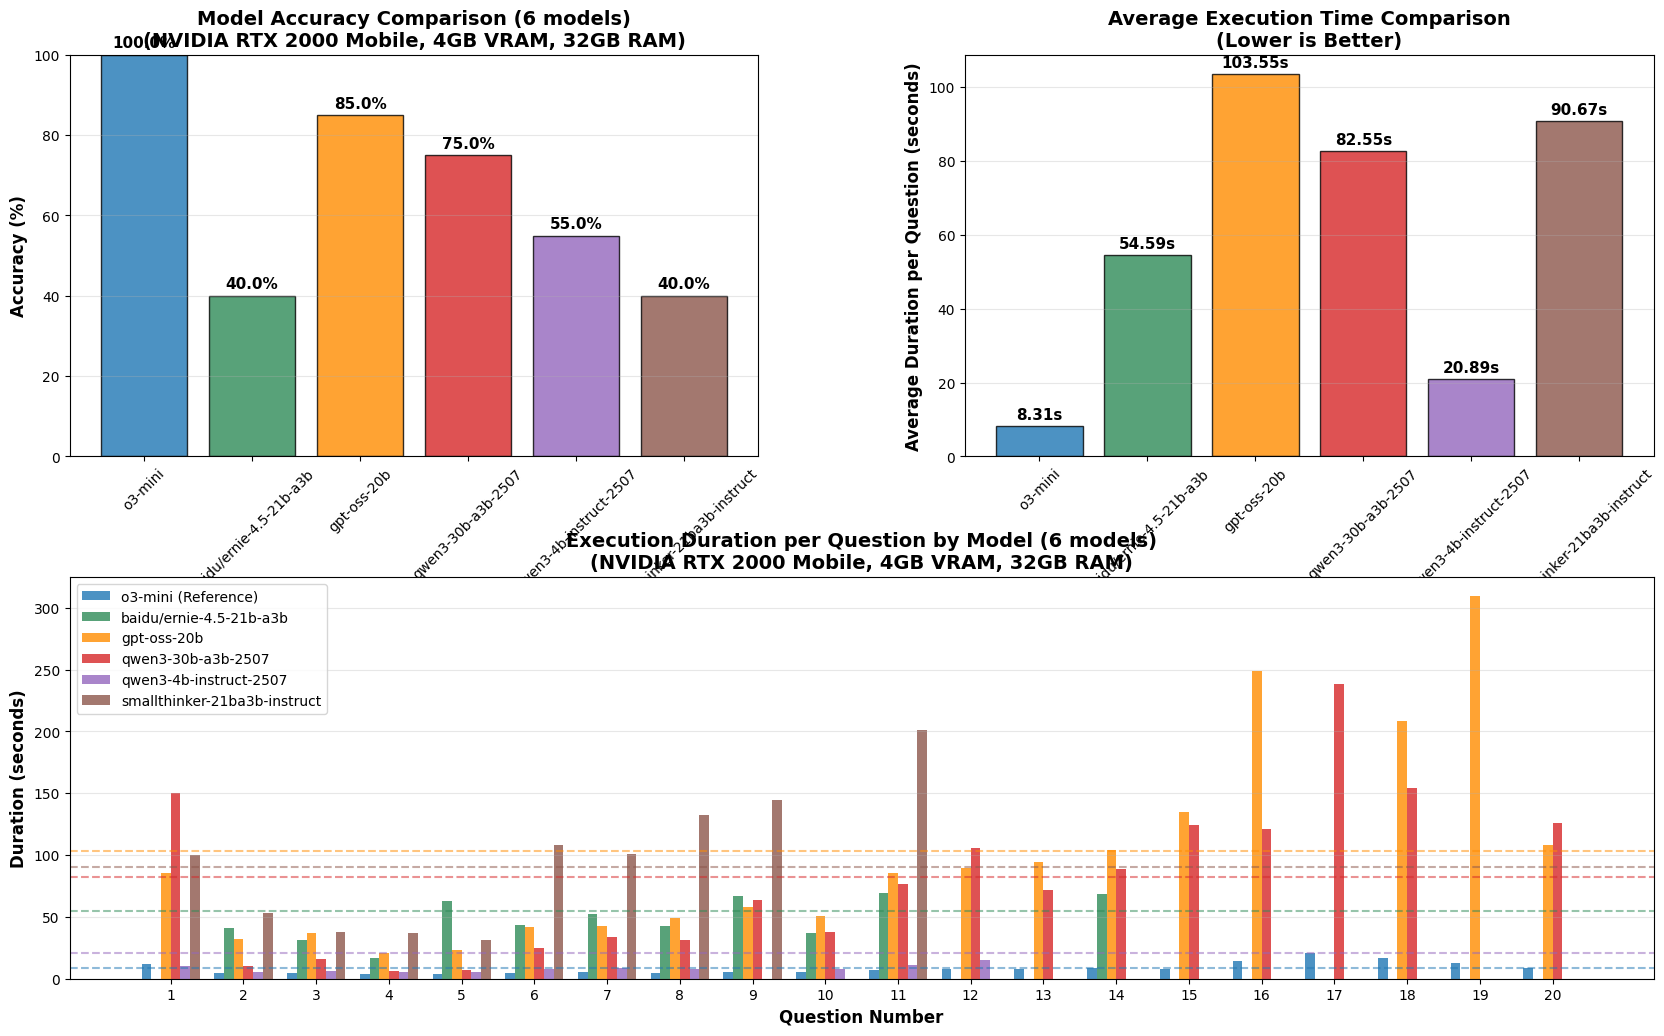


📈 ENHANCED PERFORMANCE SUMMARY (WITH FEEDBACK LOOP) - 6 MODELS:
🤖 o3-mini (Ground Truth Reference):
   • Accuracy: 100.0% (20.0/20 questions)
   • Avg Time/Question: 8.31s
   • Feedback Usage: 0.0 total iterations across 0.0 questions (avg: 0.0/question)
   • Breakdown: 20.0 exact, 0.0 superset, 0.0 subset, 0.0 mismatch, 0.0 errors

🤖 baidu/ernie-4.5-21b-a3b:
   • Accuracy: 40.0% (8.0/20 questions)
   • Avg Time/Question: 54.59s
   • Feedback Usage: 3.0 total iterations across 1.0 questions (avg: 0.2/question)
   • Breakdown: 8.0 exact, 0.0 superset, 0.0 subset, 3.0 mismatch, 9.0 errors

🤖 gpt-oss-20b:
   • Accuracy: 85.0% (17.0/20 questions)
   • Avg Time/Question: 103.55s
   • Feedback Usage: nan total iterations across 0.0 questions (avg: nan/question)
   • Breakdown: 14.0 exact, 3.0 superset, 0.0 subset, 2.0 mismatch, 1.0 errors

🤖 qwen3-30b-a3b-2507:
   • Accuracy: 75.0% (15.0/20 questions)
   • Avg Time/Question: 82.55s
   • Feedback Usage: nan total iterations across 0.0 questi

In [30]:
# 📊 Visualization: Model Performance Bar Chart
import matplotlib.pyplot as plt
import numpy as np

# Create a comprehensive dashboard with 3 charts
fig = plt.figure(figsize=(18, 12))

# Create a grid layout: 2 rows, 2 columns with bottom spanning
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Chart 1: Accuracy and Performance Metrics (top-left)
ax1 = fig.add_subplot(gs[0, 0])
models = comparison_table['model'].tolist()
accuracy = comparison_table['accuracy_percent'].tolist()
avg_time = comparison_table['avg_duration_per_question'].tolist()

# Dynamic color palette - generate enough colors for all models
base_colors = ['#1f77b4', '#2e8b57', '#ff8c00', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# Extend colors if we have more models than base colors
model_colors_list = (base_colors * ((len(models) // len(base_colors)) + 1))[:len(models)]

# Accuracy bar chart
bars1 = ax1.bar(models, accuracy, color=model_colors_list, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Model Accuracy Comparison ({len(models)} models)\n(NVIDIA RTX 2000 Mobile, 4GB VRAM, 32GB RAM)', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Add accuracy values on top of bars
for bar, acc in zip(bars1, accuracy):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Rotate x-axis labels if many models
if len(models) > 4:
    ax1.tick_params(axis='x', rotation=45)

# Chart 2: Average Duration Comparison (top-right)
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(models, avg_time, color=model_colors_list, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_ylabel('Average Duration per Question (seconds)', fontsize=12, fontweight='bold')
ax2.set_title('Average Execution Time Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add duration values on top of bars
for bar, duration in zip(bars2, avg_time):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(avg_time) * 0.01,
             f'{duration}s', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Rotate x-axis labels if many models
if len(models) > 4:
    ax2.tick_params(axis='x', rotation=45)

# Chart 3: Duration per Query by Model (bottom, spanning full width)
ax3 = fig.add_subplot(gs[1, :])

# Get individual question durations for each model dynamically
try:
    # Use models from comparison_table instead of hardcoded model list
    models_sql = "', '".join(models)
    durations_by_question = duckdb.sql(f"""
        SELECT 
            r.model,
            r.nbr as question_number,
            r.duration_s,
            r.error_details
        FROM results_filtered_three r
        WHERE r.model IN ('{models_sql}')
        ORDER BY r.nbr, r.model
    """).df()
    
    # Create dynamic color mapping for all models
    model_colors = {model: color for model, color in zip(models, model_colors_list)}
    
    # Prepare data for grouped bar chart
    questions = range(1, 21)
    num_models = len(models)
    width = 0.8 / num_models  # Dynamic width based on number of models
    x = np.arange(len(questions))
    
    # Get durations for each model dynamically
    model_durations = {}
    for model in models:
        durations = []
        for q in questions:
            model_data = durations_by_question[
                (durations_by_question['model'] == model) & 
                (durations_by_question['question_number'] == q)
            ]
            if not model_data.empty and model_data['error_details'].isna().iloc[0]:
                durations.append(model_data['duration_s'].iloc[0])
            else:
                durations.append(0)  # 0 for errors
        model_durations[model] = durations
    
    # Create grouped bar chart dynamically
    bars_list = []
    for i, model in enumerate(models):
        offset = (i - (num_models - 1) / 2) * width
        label = f'{model}' + (' (Reference)' if model == model0 else '')
        bars = ax3.bar(x + offset, model_durations[model], width, 
                      label=label, color=model_colors[model], alpha=0.8)
        bars_list.append(bars)
    
    ax3.set_xlabel('Question Number', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Duration (seconds)', fontsize=12, fontweight='bold')
    ax3.set_title(f'Execution Duration per Question by Model ({len(models)} models)\n(NVIDIA RTX 2000 Mobile, 4GB VRAM, 32GB RAM)', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(questions)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Add average lines for all models
    for model in models:
        model_data = comparison_table[comparison_table['model'] == model]
        if not model_data.empty:
            model_avg = model_data['avg_duration_per_question'].iloc[0]
            ax3.axhline(y=model_avg, color=model_colors[model], linestyle='--', alpha=0.5)
    
except Exception as e:
    # Fallback if query fails
    ax3.text(0.5, 0.5, f'Could not generate duration chart:\n{str(e)}', 
             transform=ax3.transAxes, ha='center', va='center', fontsize=12)
    ax3.set_title('Duration per Query (Data Unavailable)', fontsize=14, fontweight='bold')

# Use subplots_adjust instead of tight_layout to avoid compatibility issues
plt.subplots_adjust(left=0.06, bottom=0.15, right=0.94, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Print enhanced summary statistics including feedback loop data
print(f"\n📈 ENHANCED PERFORMANCE SUMMARY (WITH FEEDBACK LOOP) - {len(models)} MODELS:")
print("=" * 80)
for i, model in enumerate(models):
    avg_feedback = comparison_table.iloc[i]['avg_feedback_per_question']
    total_fb = comparison_table.iloc[i]['total_feedback_iterations']
    questions_fb = comparison_table.iloc[i]['questions_with_feedback']
    exact = comparison_table.iloc[i]['exact_matches']
    superset = comparison_table.iloc[i]['superset_matches']
    subset = comparison_table.iloc[i]['subset_matches']
    mismatch = comparison_table.iloc[i]['mismatches']
    errors = comparison_table.iloc[i]['errors']
    
    reference_note = " (Ground Truth Reference)" if model == model0 else ""
    print(f"🤖 {model}{reference_note}:")
    print(f"   • Accuracy: {accuracy[i]}% ({comparison_table.iloc[i]['total_correct']}/20 questions)")
    print(f"   • Avg Time/Question: {avg_time[i]}s")
    print(f"   • Feedback Usage: {total_fb} total iterations across {questions_fb} questions (avg: {avg_feedback}/question)")
    print(f"   • Breakdown: {exact} exact, {superset} superset, {subset} subset, {mismatch} mismatch, {errors} errors")
    print()

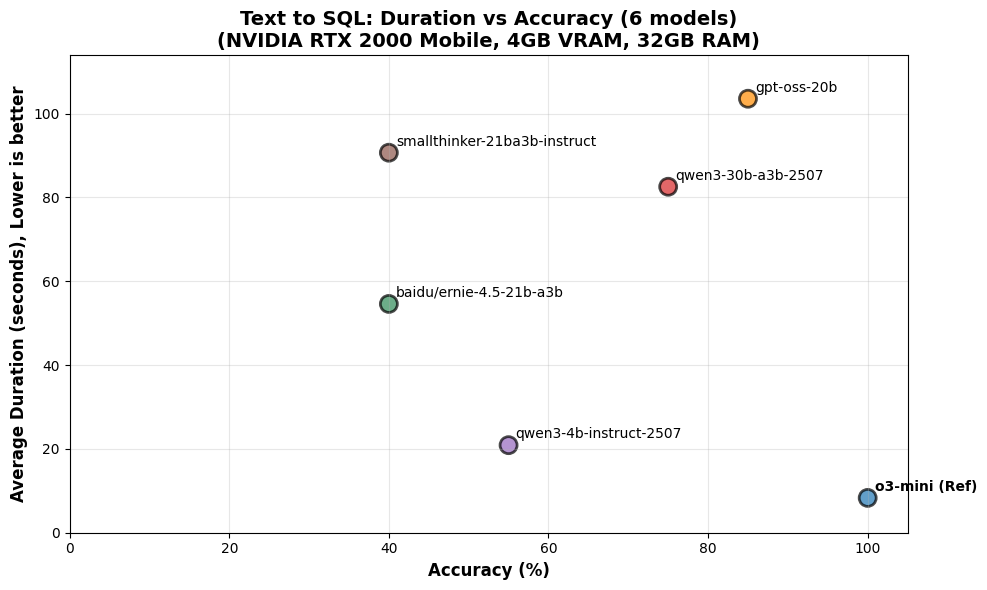

📊 DURATION vs ACCURACY SUMMARY (6 models):
o3-mini (Reference):
  • Accuracy: 100.0%
  • Avg Duration: 8.31s per question

baidu/ernie-4.5-21b-a3b:
  • Accuracy: 40.0%
  • Avg Duration: 54.59s per question

gpt-oss-20b:
  • Accuracy: 85.0%
  • Avg Duration: 103.55s per question

qwen3-30b-a3b-2507:
  • Accuracy: 75.0%
  • Avg Duration: 82.55s per question

qwen3-4b-instruct-2507:
  • Accuracy: 55.0%
  • Avg Duration: 20.89s per question

smallthinker-21ba3b-instruct:
  • Accuracy: 40.0%
  • Avg Duration: 90.67s per question



In [31]:
# 📊 Simple Scatter Plot: Speed vs Accuracy
import matplotlib.pyplot as plt
import numpy as np

# Extract data from comparison table
models = comparison_table['model'].tolist()
accuracy = comparison_table['accuracy_percent'].tolist()
avg_time = comparison_table['avg_duration_per_question'].tolist()

# Create simple scatter plot
plt.figure(figsize=(10, 6))

# Dynamic color palette for scatter plot
base_colors = ['#1f77b4', '#2e8b57', '#ff8c00', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = (base_colors * ((len(models) // len(base_colors)) + 1))[:len(models)]

# Create scatter plot
plt.scatter(accuracy, avg_time, c=colors, s=150, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, model in enumerate(models):
    label = f'{model}' + (' (Ref)' if model == model0 else '')
    plt.annotate(label, (accuracy[i], avg_time[i]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold' if model == model0 else 'normal')

# Customize plot
plt.xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.ylabel('Average Duration (seconds), Lower is better', fontsize=12, fontweight='bold')
plt.title(f'Text to SQL: Duration vs Accuracy ({len(models)} models)\n(NVIDIA RTX 2000 Mobile, 4GB VRAM, 32GB RAM)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Set axis limits with some padding
plt.xlim(0, 105)
plt.ylim(0, max(avg_time) * 1.1 if max(avg_time) > 0 else 0.1)

plt.tight_layout()
plt.show()

# Print summary
print(f"📊 DURATION vs ACCURACY SUMMARY ({len(models)} models):")
print("=" * 50)
for i, model in enumerate(models):
    reference_note = " (Reference)" if model == model0 else ""
    print(f"{model}{reference_note}:")
    print(f"  • Accuracy: {accuracy[i]}%")
    print(f"  • Avg Duration: {avg_time[i]}s per question")
    print()

In [32]:
# 🔥 Show all Queries 🔥


# Get EVERYTHING - all questions, all models, all match types (dynamic)
# Get comparison models from comparison_table
comparison_models = [model for model in models if model != model0]
comparison_models_sql = "', '".join(comparison_models) if comparison_models else ""

all_questions_analysis = duckdb.sql(f"""
    WITH source_results AS (
        SELECT nbr, 
               all_values as source_values,
               sorted_values_hash as source_sorted_hash,
               result_count as source_rows,
               sql_query as source_sql,
               question
        FROM results_filtered_three 
        WHERE model = '{model0}' AND error_details IS NULL
    ),
    model_scores AS (
        SELECT 
            r.model,
            r.nbr,
            r.question,
            r.sql_query as model_sql,
            r.result_count,
            r.error_details,
            r.feedback_iterations,
            s.source_rows,
            s.source_sql,
            CASE 
                WHEN r.error_details IS NOT NULL THEN 'error'
                WHEN r.sorted_values_hash = s.source_sorted_hash THEN 'exact'
                WHEN array_has_all(r.all_values, s.source_values) THEN 'superset'
                WHEN array_has_all(s.source_values, r.all_values) THEN 'subset'
                ELSE 'mismatch'
            END as match_type
        FROM results_filtered_three r
        LEFT JOIN source_results s ON r.nbr = s.nbr
        WHERE r.model IN ('{comparison_models_sql}')
    )
    SELECT nbr, question, model, model_sql, source_sql, result_count, source_rows, match_type, error_details, feedback_iterations
    FROM model_scores
    ORDER BY nbr, model
""").df() if comparison_models else pd.DataFrame()

print(f"📈 COMPLETE ANALYSIS SUMMARY ({len(models)} models):")
print(f"   Total Comparisons: {len(all_questions_analysis)}")

# Show comprehensive breakdown by match type
if not all_questions_analysis.empty:
    match_type_counts = all_questions_analysis['match_type'].value_counts()
    for match_type, count in match_type_counts.items():
        emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥"}.get(match_type, "❓")
        percentage = (count / len(all_questions_analysis)) * 100
        print(f"   {emoji} {match_type}: {count} ({percentage:.1f}%)")
else:
    print("   No comparison data available.")
print()

from IPython.display import HTML
import html

# Process EVERY SINGLE QUESTION (1-20)
for question_num in range(1, 21):
    print(f"📋 QUESTION {question_num}")
    print("=" * 80)
    
    # Get question text from reference model
    try:
        question_text = duckdb.sql(f"""
            SELECT question FROM results_filtered_three 
            WHERE model = '{model0}' AND nbr = {question_num}
        """).fetchone()[0]
        print(f"❓ Question: {question_text}")
    except:
        print(f"❓ Question: [Could not retrieve question text]")
    
    # Get data for this question
    question_data = all_questions_analysis[all_questions_analysis['nbr'] == question_num]
    
    if len(question_data) == 0:
        print("⚠️ No data found for this question")
        print("=" * 80 + "\n")
        continue
    
    # Show match status for each model
    print(f"🏷️ Match Results:")
    for _, row in question_data.iterrows():
        model_name = row['model']
        match_type = row['match_type']
        feedback_iterations = row['feedback_iterations']
        emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥"}.get(match_type, "❓")
        
        # Handle NA values in feedback_iterations
        if pd.isna(feedback_iterations) or feedback_iterations == 0:
            feedback_info = ""
        else:
            feedback_info = f" (🔄 {feedback_iterations} feedback iterations)"
        
        if row['error_details']:
            print(f"   {emoji} {model_name}: {match_type}{feedback_info} - {row['error_details']}")
        else:
            print(f"   {emoji} {model_name}: {match_type}{feedback_info}")
    print()
    
    # Get reference result and SQL
    try:
        source_sql = duckdb.sql(f"""
            SELECT sql_query FROM results_filtered_three 
            WHERE model = '{model0}' AND nbr = {question_num} AND error_details IS NULL
        """).fetchone()[0]
        
        source_result = con.sql(source_sql).df()
        
        # Get results for all models (dynamic)
        all_models_for_question = [model0] + question_data['model'].tolist()
        all_results = [source_result]
        all_sqls = [source_sql]
        all_match_types = ['reference']
        
        # Get results for comparison models
        for _, row in question_data.iterrows():
            model_name = row['model']
            model_sql = row['model_sql']
            match_type = row['match_type']
            
            try:
                if row['error_details']:
                    # Add empty result for errors
                    all_results.append(pd.DataFrame({'Error': [row['error_details']]}))
                    all_sqls.append(model_sql)
                else:
                    model_result = con.sql(model_sql).df()
                    all_results.append(model_result)
                    all_sqls.append(model_sql)
                all_match_types.append(match_type)
            except Exception as e:
                all_results.append(pd.DataFrame({'Execution_Error': [str(e)]}))
                all_sqls.append(model_sql)
                all_match_types.append('execution_error')
        
        # Create comprehensive side-by-side comparison
        if len(all_results) > 1:
            max_rows = max(len(df) for df in all_results if len(df) > 0)
            if max_rows == 0:
                max_rows = 1
            
            padded_results = []
            for i, df in enumerate(all_results):
                if len(df) == 0:
                    padded_df = pd.DataFrame({'No_Data': ['Empty result']})
                elif len(df) < max_rows:
                    empty_rows = max_rows - len(df)
                    if empty_rows > 0:
                        # Create empty DataFrame with proper data types matching the original
                        if not df.empty and len(df.columns) > 0:
                            # Use the original DataFrame's dtypes for empty rows
                            empty_data = {}
                            for col in df.columns:
                                # Create empty values with the same dtype as the original column
                                if df[col].dtype == 'object':
                                    empty_data[col] = [None] * empty_rows
                                elif df[col].dtype in ['int64', 'int32']:
                                    empty_data[col] = [pd.NA] * empty_rows
                                elif df[col].dtype in ['float64', 'float32']:
                                    empty_data[col] = [float('nan')] * empty_rows
                                else:
                                    empty_data[col] = [None] * empty_rows
                            
                            empty_df = pd.DataFrame(empty_data)
                            # Ensure dtypes match before concatenation
                            for col in df.columns:
                                if col in empty_df.columns:
                                    try:
                                        empty_df[col] = empty_df[col].astype(df[col].dtype)
                                    except:
                                        pass  # Keep original dtype if conversion fails
                            
                            padded_df = pd.concat([df, empty_df], ignore_index=True)
                        else:
                            # If original DataFrame is empty, create a simple empty DataFrame
                            padded_df = pd.DataFrame({'No_Data': ['Empty result'] * max_rows})
                    else:
                        padded_df = df.copy()
                else:
                    padded_df = df.copy()
                
                padded_results.append(padded_df)
            
            # Create model labels with match types
            model_labels = []
            for i, (model, match_type) in enumerate(zip(all_models_for_question, all_match_types)):
                if i == 0:
                    model_labels.append(f'{model} (Reference)')
                else:
                    emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥", "execution_error": "💥"}.get(match_type, "❓")
                    model_labels.append(f'{model} ({emoji} {match_type})')
            
            # Create multi-column comparison
            side_by_side = pd.concat(padded_results, 
                                   axis=1, 
                                   keys=model_labels[:len(padded_results)])
            
            print("📊 Complete Results Comparison:")
            display(side_by_side)
            
            # Create comprehensive HTML SQL comparison
            html_sections = []
            for i, (model_name, sql_query, match_type) in enumerate(zip(all_models_for_question, all_sqls, all_match_types)):
                if i == 0:
                    color = "#2e8b57"
                    bg_color = "#f8f9fa"
                    label = f"{model_name} SQL (Reference)"
                else:
                    emoji = {"exact": "✅", "superset": "⬆️", "subset": "⬇️", "mismatch": "❌", "error": "💥", "execution_error": "💥"}.get(match_type, "❓")
                    
                    if match_type == 'exact':
                        color = "#28a745"  # Green for exact
                        bg_color = "#f8fff8"
                    elif match_type in ['superset', 'subset']:
                        color = "#ff8c00"  # Orange for valid differences
                        bg_color = "#fff8dc"
                    else:
                        color = "#dc3545"  # Red for errors/mismatches
                        bg_color = "#fff5f5"
                    
                    label = f"{model_name} SQL ({emoji} {match_type})"
                
                section = f"""
                    <div style="flex: 1; border: 1px solid #ddd; padding: 10px; min-width: 300px; margin: 5px;">
                        <h4 style="color: {color}; margin-top: 0; margin-bottom: 10px;">{label}</h4>
                        <pre style="background-color: {bg_color}; padding: 10px; border-radius: 4px; white-space: pre-wrap; font-size: 11px; color: black; max-height: 300px; overflow-y: auto;">{html.escape(sql_query)}</pre>
                    </div>"""
                html_sections.append(section)
            
            html_content = f"""
            <div style="display: flex; gap: 10px; margin: 10px 0; flex-wrap: wrap; justify-content: space-around;">
                {''.join(html_sections)}
            </div>
            """
            
            print("🔧 Complete SQL Queries Comparison:")
            display(HTML(html_content))
            
    except Exception as e:
        print(f"❌ Error processing question {question_num}: {e}")
    
    print("=" * 80 + "\n")

print("🎯 COMPLETE ANALYSIS FINISHED - EVERY QUESTION SHOWN")
print("=" * 80)

📈 COMPLETE ANALYSIS SUMMARY (6 models):
   Total Comparisons: 100
   ✅ exact: 52 (52.0%)
   💥 error: 30 (30.0%)
   ❌ mismatch: 11 (11.0%)
   ⬆️ superset: 5 (5.0%)
   ⬇️ subset: 2 (2.0%)

📋 QUESTION 1
❓ Question: What is the overall total sales revenue?
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:


,o3-mini (Reference),baidu/ernie-4.5-21b-a3b (💥 error),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact),qwen3-4b-instruct-2507 (✅ exact),smallthinker-21ba3b-instruct (✅ exact)
,total_sales,Error,total_sales_revenue,total_sales_revenue,total_sales_revenue,total_sales_revenue
0,5.143009e+08,AI Error: Error connecting to Ollama/LM Studio...,5.143009e+08,5.143009e+08,5.143009e+08,5.143009e+08


🔧 Complete SQL Queries Comparison:



📋 QUESTION 2
❓ Question: What is the total number of items sold across all transactions?
🏷️ Match Results:
   ❌ baidu/ernie-4.5-21b-a3b: mismatch
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:


,o3-mini (Reference),baidu/ernie-4.5-21b-a3b (❌ mismatch),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact),qwen3-4b-instruct-2507 (✅ exact),smallthinker-21ba3b-instruct (✅ exact)
,total_quantity,total_items_sold,total_items_sold,total_items_sold,total_quantity,total_items_sold
0,13939520.0,13614791.0,13939520.0,13939520.0,13939520.0,13939520.0


🔧 Complete SQL Queries Comparison:



📋 QUESTION 3
❓ Question: What is the total monetary value of all returned items?
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:


,o3-mini (Reference),baidu/ernie-4.5-21b-a3b (✅ exact),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact),qwen3-4b-instruct-2507 (✅ exact),smallthinker-21ba3b-instruct (✅ exact)
,total_returns,total_returned_monetary_value,total_monetary_value_of_returns,total_monetary_value_of_returns,total_monetary_value_of_returns,total_returned_value
0,26706800.77,26706800.77,26706800.77,26706800.77,26706800.77,26706800.77


🔧 Complete SQL Queries Comparison:



📋 QUESTION 4
❓ Question: List the names of all stores, order by store name.
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:


,o3-mini (Reference),baidu/ernie-4.5-21b-a3b (✅ exact),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact),qwen3-4b-instruct-2507 (✅ exact),smallthinker-21ba3b-instruct (✅ exact)
,s_store_name,s_store_name,store_name,s_store_name,s_store_name,s_store_name
0,ought,ought,ought,ought,ought,ought


🔧 Complete SQL Queries Comparison:



📋 QUESTION 5
❓ Question: What are the different item categories available? Order alphabetically by category name.
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact (🔄 3 feedback iterations)
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:


,o3-mini (Reference),baidu/ernie-4.5-21b-a3b (✅ exact),gpt-oss-20b (✅ exact),qwen3-30b-a3b-2507 (✅ exact),qwen3-4b-instruct-2507 (✅ exact),smallthinker-21ba3b-instruct (✅ exact)
,i_category,i_category,category_name,i_category,i_category,i_category
0,Books,Books,Books,Books,Books,Books
1,Children,Children,Children,Children,Children,Children
2,Electronics,Electronics,Electronics,Electronics,Electronics,Electronics
3,Home,Home,Home,Home,Home,Home
4,Jewelry,Jewelry,Jewelry,Jewelry,Jewelry,Jewelry
5,Men,Men,Men,Men,Men,Men
6,Music,Music,Music,Music,Music,Music
7,Shoes,Shoes,Shoes,Shoes,Shoes,Shoes
8,Sports,Sports,Sports,Sports,Sports,Sports


🔧 Complete SQL Queries Comparison:



📋 QUESTION 6
❓ Question: Show total sales revenue for each year, ordered chronologically by year.
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:


o3-mini (Reference)               baidu/ernie-4.5-21b-a3b (✅ exact)  \
               d_year   total_sales                            d_year   
0                1998  1.022972e+08                              1998   
1                1999  9.937045e+07                              1999   
2                2000  1.031840e+08                              2000   
3                2001  1.021729e+08                              2001   
4                2002  1.002891e+08                              2002   
5                2003  8.737749e+05                              2003   

                gpt-oss-20b (✅ exact)                      \
    total_sales                  year total_sales_revenue   
0  1.022972e+08                  1998        1.022972e+08   
1  9.937045e+07                  1999        9.937045e+07   
2  1.031840e+08                  2000        1.031840e+08   
3  1.021729e+08                  2001        1.021729e+08   
4  1.002891e+08                  2002        1.002891e+08   
5  8.737749e+05                  2003        8.737749e+05   

  qwen3-30b-a3b-2507 (✅ exact)                      \
                        d_year total_sales_revenue   
0                         1998        1.022972e+08   
1                         1999        9.937045e+07   
2                         2000        1.031840e+08   
3                         2001        1.021729e+08   
4                         2002        1.002891e+08   
5                         2003        8.737749e+05   

  qwen3-4b-instruct-2507 (✅ exact)                      \
                              year total_sales_revenue   
0                             1998        1.022972e+08   
1                             1999        9.937045e+07   
2                             2000        1.031840e+08   
3                             2001        1.021729e+08   
4                             2002        1.002891e+08   
5                             2003        8.737749e+05   

  smallthinker-21ba3b-instruct (✅ exact)                  
                                  d_year total_sales_amt  
0                                   1998    1.022972e+08  
1                                   1999    9.937045e+07  
2                                   2000    1.031840e+08  
3                                   2001    1.021729e+08  
4                                   2002    1.002891e+08  
5                                   2003    8.737749e+05

🔧 Complete SQL Queries Comparison:



📋 QUESTION 7
❓ Question: Which store generated the most total sales revenue? (To ensure a deterministic result if there's a tie, you might order by revenue descending and then store name alphabetically).
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ⬇️ qwen3-30b-a3b-2507: subset
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 2 feedback iterations)

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)               baidu/ernie-4.5-21b-a3b (✅ exact)  \
         s_store_name   total_sales                        store_name   
0               ought  5.079412e+08                             ought   

                gpt-oss-20b (✅ exact)                \
    total_sales          s_store_name   total_sales   
0  5.079412e+08                 ought  5.079412e+08   

  qwen3-30b-a3b-2507 (⬇️ subset) qwen3-4b-instruct-2507 (✅ exact)  \
                    s_store_name                            store   
0                          ought                            ought   

                smallthinker-21ba3b-instruct (✅ exact)                
    total_sales                           s_store_name   total_sales  
0  5.079412e+08                                  ought  5.079412e+08

🔧 Complete SQL Queries Comparison:



📋 QUESTION 8
❓ Question: What is the total quantity of items sold, broken down by item brand? Order by quantity sold descending, and then by brand name alphabetically for ties.
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ❌ smallthinker-21ba3b-instruct: mismatch (🔄 3 feedback iterations)

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)                baidu/ernie-4.5-21b-a3b (✅ exact)  \
                 i_brand total_quantity                             brand   
0      exportischolar #2       329402.0                 exportischolar #2   
1     edu packimporto #2       279745.0                edu packimporto #2   
2        amalgexporti #2       256831.0                   amalgexporti #2   
3      importoimporto #2       251018.0                 importoimporto #2   
4        importoamalg #2       244138.0                   importoamalg #2   
...                  ...            ...                               ...   
1791                None            NaN                              None   
1792                None            NaN                              None   
1793                None            NaN                              None   
1794                None            NaN                              None   
1795                None            NaN                              None   

                         gpt-oss-20b (✅ exact)                      \
     total_sold_quantity                 brand total_quantity_sold   
0               329402.0     exportischolar #2            329402.0   
1               279745.0    edu packimporto #2            279745.0   
2               256831.0       amalgexporti #2            256831.0   
3               251018.0     importoimporto #2            251018.0   
4               244138.0       importoamalg #2            244138.0   
...                  ...                   ...                 ...   
1791                 NaN                  None                 NaN   
1792                 NaN                  None                 NaN   
1793                 NaN                  None                 NaN   
1794                 NaN                  None                 NaN   
1795                 NaN                  None                 NaN   

     qwen3-30b-a3b-2507 (✅ exact)                 \
                          i_brand total_quantity   
0               exportischolar #2       329402.0   
1              edu packimporto #2       279745.0   
2                 amalgexporti #2       256831.0   
3               importoimporto #2       251018.0   
4                 importoamalg #2       244138.0   
...                           ...            ...   
1791                         None            NaN   
1792                         None            NaN   
1793                         None            NaN   
1794                         None            NaN   
1795                         None            NaN   

     qwen3-4b-instruct-2507 (✅ exact)                 \
                           brand_name total_quantity   
0                   exportischolar #2       329402.0   
1                  edu packimporto #2       279745.0   
2                     amalgexporti #2       256831.0   
3                   importoimporto #2       251018.0   
4                     importoamalg #2       244138.0   
...                               ...            ...   
1791                             None            NaN   
1792                             None            NaN   
1793                             None            NaN   
1794                             None            NaN   
1795                             None            NaN   

     smallthinker-21ba3b-instruct (❌ mismatch)                      
                                       i_brand total_quantity_sold  
0                            exportischolar #2            322219.0  
1                            exportischolar #2            322219.0  
2                            exportischolar #2            322219.0  
3                            exportischolar #2            322219.0  
4                            exportischolar #2            322219.0  
...                                        ...                 ...  
1791                        corpamalgamalg #17              2415.0  
1792                           exportibrand #9              2383.

🔧 Complete SQL Queries Comparison:



📋 QUESTION 9
❓ Question: Compare total sales from preferred customers versus non-preferred customers, ordered by total sales
🏷️ Match Results:
   ❌ baidu/ernie-4.5-21b-a3b: mismatch
   ❌ gpt-oss-20b: mismatch
   ❌ qwen3-30b-a3b-2507: mismatch
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   ❌ smallthinker-21ba3b-instruct: mismatch

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)               baidu/ernie-4.5-21b-a3b (❌ mismatch)  \
   preferred_customer   total_sales                        customer_type   
0                   N  2.461229e+08                        Non-Preferred   
1                   Y  2.456942e+08                            Preferred   
2                None  1.625229e+07                                 None   

                                                gpt-oss-20b (❌ mismatch)  \
   sales_amount customer_count sales_percentage            customer_type   
0  2.623752e+08           4687            51.64            Non-Preferred   
1  2.456942e+08           4358            48.36                Preferred   
2           NaN           <NA>              NaN            Non-Preferred   

                qwen3-30b-a3b-2507 (❌ mismatch)                \
    total_sales             customer_preference   total_sales   
0  2.461229e+08                               Y  2.456942e+08   
1  2.456942e+08                               N  0.000000e+00   
2  1.625229e+07                            None           NaN   

                    qwen3-4b-instruct-2507 (💥 error)  \
                                               Error   
0  Execution Error: Failed to get corrected query...   
1                                               None   
2                                               None   

  smallthinker-21ba3b-instruct (❌ mismatch)  
                                  net_sales  
0                              4.875941e+08  
1                                       NaN  
2                                       NaN

🔧 Complete SQL Queries Comparison:



📋 QUESTION 10
❓ Question: What is the total return amount for each city where stores are located, ordered alphabetically by city name.
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   💥 smallthinker-21ba3b-instruct: error - Execution Error: Max attempts reached. Last error: Binder Error: Table "ss" does not have a column named "s_store_name"

Candidate bindings: : "ss_store_sk"

LINE 14:     GROUP BY ss.s_store_name
                      ^

📊 Complete Results Comparison:


o3-mini (Reference)               baidu/ernie-4.5-21b-a3b (✅ exact)  \
                 city total_returns                            s_city   
0              Midway   26153478.62                            Midway   

                gpt-oss-20b (✅ exact)                       \
  total_returns                  city total_returns_amount   
0   26153478.62                Midway          26153478.62   

  qwen3-30b-a3b-2507 (✅ exact)               qwen3-4b-instruct-2507 (✅ exact)  \
                          city total_returns                           s_city   
0                       Midway   26153478.62                           Midway   

                            smallthinker-21ba3b-instruct (💥 error)  
  total_returns                                              Error  
0   26153478.62  Execution Error: Max attempts reached. Last er...

🔧 Complete SQL Queries Comparison:



📋 QUESTION 11
❓ Question: What is the net sales for each store name, order by net sales.
🏷️ Match Results:
   ✅ baidu/ernie-4.5-21b-a3b: exact
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   ✅ qwen3-4b-instruct-2507: exact
   ✅ smallthinker-21ba3b-instruct: exact (🔄 3 feedback iterations)

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)              baidu/ernie-4.5-21b-a3b (✅ exact)  \
           store_name    net_sales                        store_name   
0               ought  481787676.8                             ought   

               gpt-oss-20b (✅ exact)               \
     net_sales            store_name    net_sales   
0  481787676.8                 ought  481787676.8   

  qwen3-30b-a3b-2507 (✅ exact)              qwen3-4b-instruct-2507 (✅ exact)  \
                    store_name    net_sales                       store_name   
0                        ought  481787676.8                            ought   

               smallthinker-21ba3b-instruct (✅ exact)               
     net_sales                             store_name    net_sales  
0  481787676.8                                  ought  481787676.8

🔧 Complete SQL Queries Comparison:



📋 QUESTION 12
❓ Question: Calculate the return rate for each item category, ordered alphabetically by item category name.
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ✅ gpt-oss-20b: exact
   ⬆️ qwen3-30b-a3b-2507: superset
   ⬆️ qwen3-4b-instruct-2507: superset
   💥 smallthinker-21ba3b-instruct: error - Execution Error: Max attempts reached. Last error: Binder Error: Referenced table "i" not found!
Candidate tables: "s"

LINE 23: GROUP BY i.category;
                  ^

📊 Complete Results Comparison:


o3-mini (Reference)              \
         item_category return_rate   
0                Books    5.163511   
1             Children    4.903206   
2          Electronics    5.203537   
3                 Home    5.118729   
4              Jewelry    5.123106   
5                  Men    5.331012   
6                Music    5.357483   
7                Shoes    5.145126   
8               Sports    5.290199   
9                Women    5.246700   
10                None    0.000000   
11                None         NaN   

                    baidu/ernie-4.5-21b-a3b (💥 error) gpt-oss-20b (✅ exact)  \
                                                Error         item_category   
0   AI Error: Error connecting to Ollama/LM Studio...                 Books   
1                                                None              Children   
2                                                None           Electronics   
3                                                None                  Home   
4                                                None               Jewelry   
5                                                None                   Men   
6                                                None                 Music   
7                                                None                 Shoes   
8                                                None                Sports   
9                                                None                 Women   
10                                               None                  None   
11                                               None                  None   

                       qwen3-30b-a3b-2507 (⬆️ superset)               \
   return_rate_percent                    item_category  total_sales   
0             5.163511                            Books  56231614.81   
1             4.903206                         Children  48923440.85   
2             5.203537                      Electronics  56084975.64   
3             5.118729                             Home  48874282.69   
4             5.123106                          Jewelry  52983266.97   
5             5.331012                              Men  50692116.25   
6             5.357483                            Music  52783919.32   
7             5.145126                            Shoes  47807842.49   
8             5.290199                           Sports  43870221.97   
9             5.246700                            Women  54383250.42   
10                 NaN                             None   1665936.31   
11            0.000000                             None         0.00   

                             qwen3-4b-instruct-2507 (⬆️ superset)  \
   total_returns return_rate                           i_category   
0     2903525.42    5.163511                                Books   
1     2398817.12    4.903206                             Children   
2     2918402.71    5.203537                          Electronics   
3     2501742.06    5.118729                                 Home   
4     2714389.19    5.123106                              Jewelry   
5     2702402.68    5.331012                                  Men   
6     2827889.58    5.357483                                Music   
7     2459773.92    5.145126                                Shoes   
8     2320822.09    5.290199                               Sports   
9     2853326.02    5.246700                                Women   
10          0.00    0.000000                                 None   
11     105709.98         NaN                                 None   

                                           \
    total_sales total_returns return_rate   
0   56231614.81    2903525.42    5.163511   
1   48923440.85    2398817.12    4.903206   
2   56084975.64    2918402.71    5.203537   
3   48874282.69    2501742.06    5.118729   
4   52983266.97    2714389.19    5.123106   
5   50692116.25    2702402.68    5.331012   
6   52783919.32    2827889.

🔧 Complete SQL Queries Comparison:



📋 QUESTION 13
❓ Question: What is the monthly trend of net sales during the year 2001, order by net sales desc
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   💥 smallthinker-21ba3b-instruct: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)

📊 Complete Results Comparison:


o3-mini (Reference)               \
                 month    net_sales   
0                   12  17167258.39   
1                   11  16207294.58   
2                    9  11365462.90   
3                   10  10717099.39   
4                    8  10489886.43   
5                    1   5177088.03   
6                    5   4686864.37   
7                    3   4436523.60   
8                    7   4418270.78   
9                    4   4336369.48   
10                   2   4033130.36   
11                   6   3909591.47   

                    baidu/ernie-4.5-21b-a3b (💥 error) gpt-oss-20b (✅ exact)  \
                                                Error                 month   
0   AI Error: Error connecting to Ollama/LM Studio...                    12   
1                                                None                    11   
2                                                None                     9   
3                                                None                    10   
4                                                None                     8   
5                                                None                     1   
6                                                None                     5   
7                                                None                     3   
8                                                None                     7   
9                                                None                     4   
10                                               None                     2   
11                                               None                     6   

                qwen3-30b-a3b-2507 (✅ exact)               \
      net_sales                        month    net_sales   
0   17167258.39                           12  17167258.39   
1   16207294.58                           11  16207294.58   
2   11365462.90                            9  11365462.90   
3   10717099.39                           10  10717099.39   
4   10489886.43                            8  10489886.43   
5    5177088.03                            1   5177088.03   
6    4686864.37                            5   4686864.37   
7    4436523.60                            3   4436523.60   
8    4418270.78                            7   4418270.78   
9    4336369.48                            4   4336369.48   
10   4033130.36                            2   4033130.36   
11   3909591.47                            6   3909591.47   

                     qwen3-4b-instruct-2507 (💥 error)  \
                                                Error   
0   Execution Error: Failed to get corrected query...   
1                                                None   
2                                                None   
3                                                None   
4                                                None   
5                                                None   
6                                                None   
7                                                None   
8                                                None   
9                                                None   
10                                               None   
11                                               None   

               smallthinker-21ba3b-instruct (💥 error)  
                                                Error  
0   AI Error: Error connecting to Ollama/LM Studio...  
1                                                None  
2                                                None  
3                                                None  
4                                                None  
5                                                None  
6                                                None  
7                                                None  
8                                                None  
9                                                None  
10                     

🔧 Complete SQL Queries Comparison:



📋 QUESTION 14
❓ Question: Which customer birth country exhibits the highest average return rate Order by average return rate descending ? show only the top country and the return rate
🏷️ Match Results:
   ❌ baidu/ernie-4.5-21b-a3b: mismatch
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   💥 smallthinker-21ba3b-instruct: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)

📊 Complete Results Comparison:
📊 Complete Results Comparison:


o3-mini (Reference)             baidu/ernie-4.5-21b-a3b (❌ mismatch)  \
        birth_country return_rate                        birth_country   
0    MARSHALL ISLANDS    8.010773                          EL SALVADOR   

                  gpt-oss-20b (✅ exact)                  \
  avg_return_rate         birth_country avg_return_rate   
0       73.247752      MARSHALL ISLANDS        8.010773   

  qwen3-30b-a3b-2507 (✅ exact)              \
        customer_birth_country return_rate   
0             MARSHALL ISLANDS    8.010773   

                    qwen3-4b-instruct-2507 (💥 error)  \
                                               Error   
0  Execution Error: Failed to get corrected query...   

              smallthinker-21ba3b-instruct (💥 error)  
                                               Error  
0  AI Error: Error connecting to Ollama/LM Studio...

🔧 Complete SQL Queries Comparison:



📋 QUESTION 15
❓ Question: List all item product names and total sales that have a return rate greater than 5%, ordered by item product name alphabetically. Return only i_product_name and total_sales columns.
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ⬆️ gpt-oss-20b: superset
   ⬇️ qwen3-30b-a3b-2507: subset
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   💥 smallthinker-21ba3b-instruct: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)

📊 Complete Results Comparison:


o3-mini (Reference)              \
         i_product_name total_sales   
0                  able   317464.60   
1              ableable   262437.05   
2          ableableable   114399.12   
3          ableableeing   132341.75   
4      ableableeseought   113558.93   
..                  ...         ...   
860         pripriation   604846.13   
861      pripribarought   502711.61   
862         priprically   199231.61   
863    pripricallyought   564620.56   
864      priprieseought   197315.89   

                     baidu/ernie-4.5-21b-a3b (💥 error)  \
                                                 Error   
0    AI Error: Error connecting to Ollama/LM Studio...   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
860                                               None   
861                                               None   
862                                               None   
863                                               None   
864                                               None   

    gpt-oss-20b (⬆️ superset)                                        \
                 product_name total_sales total_returns return_rate   
0                        able   317464.60      18242.98    5.746461   
1                    ableable   262437.05      18697.28    7.124482   
2                ableableable   114399.12      12521.80   10.945714   
3                ableableeing   132341.75      15900.80   12.014954   
4            ableableeseought   113558.93       6742.09    5.937085   
..                        ...         ...           ...         ...   
860               pripriation   604846.13      48263.37    7.979446   
861            pripribarought   502711.61      33192.85    6.602762   
862               priprically   199231.61      13966.02    7.009942   
863          pripricallyought   564620.56      31938.26    5.656588   
864            priprieseought   197315.89      13728.33    6.957539   

    qwen3-30b-a3b-2507 (⬇️ subset)              \
                    i_product_name total_sales   
0                             able   317464.60   
1                         ableable   262437.05   
2                     ableableable   114399.12   
3                     ableableeing   132341.75   
4                 ableableeseought   113558.93   
..                             ...         ...   
860                    pripriation   604846.13   
861                 pripribarought   502711.61   
862                    priprically   199231.61   
863               pripricallyought   564620.56   
864                 priprieseought   197315.89   

                      qwen3-4b-instruct-2507 (💥 error)  \
                                                 Error   
0    Execution Error: Failed to get corrected query...   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
860                                               None   
861                                               None   
862                                               None   
863                                               None   
864                                               None   

                smallthinker-21ba3b-instruct (💥 error)  
                                                 Error  
0    AI Error: Error connecting to Ollama/LM Studio...  
1                                                 None  
2                                                 None  
3                                                 None  
4                                                 None  
..          

🔧 Complete SQL Queries Comparison:



📋 QUESTION 16
❓ Question: For each store, what was the percentage change in net sales between two consecutive recent years (e.g., 2001 and 2002), ordered alphabetically by store name.
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ⬆️ gpt-oss-20b: superset
   ❌ qwen3-30b-a3b-2507: mismatch
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   💥 smallthinker-21ba3b-instruct: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)

📊 Complete Results Comparison:


o3-mini (Reference)                                           \
         s_store_name net_sales_2001 net_sales_2002 pct_change   
0               ought    96358866.54    94602708.88  -1.822518   
1                None            NaN            NaN        NaN   
2                None            NaN            NaN        NaN   
3                None            NaN            NaN        NaN   
4                None            NaN            NaN        NaN   

                   baidu/ernie-4.5-21b-a3b (💥 error)  \
                                               Error   
0  AI Error: Error connecting to Ollama/LM Studio...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

  gpt-oss-20b (⬆️ superset)                                              \
                     sstore  year     prev_net  current_net  pct_change   
0                     ought  1999  98524927.98  93772296.02   -4.823786   
1                     ought  2000  93772296.02  97320871.87    3.784248   
2                     ought  2001  97320871.87  96358866.54   -0.988488   
3                     ought  2002  96358866.54  94602708.88   -1.822518   
4                     ought  2003  94602708.88  -1343830.40 -101.420499   

  qwen3-30b-a3b-2507 (❌ mismatch)                          \
                       store_name pct_change_in_net_sales   
0                           ought               -2.584388   
1                            None                     NaN   
2                            None                     NaN   
3                            None                     NaN   
4                            None                     NaN   

                    qwen3-4b-instruct-2507 (💥 error)  \
                                               Error   
0  Execution Error: Failed to get corrected query...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   

              smallthinker-21ba3b-instruct (💥 error)  
                                               Error  
0  AI Error: Error connecting to Ollama/LM Studio...  
1                                               None  
2                                               None  
3                                               None  
4                                               None

🔧 Complete SQL Queries Comparison:



📋 QUESTION 17
❓ Question: What is the return rate for items sold on weekends versus weekdays, broken down by customer age groups (e.g., under 30, 30-45, over 45), ordered by age group.
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   💥 gpt-oss-20b: error - Execution Error: Max attempts reached. Last error: Binder Error: Ambiguous reference to column name "age_group" (use: "s.age_group" or "r.age_group")
   ❌ qwen3-30b-a3b-2507: mismatch
   💥 qwen3-4b-instruct-2507: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   💥 smallthinker-21ba3b-instruct: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', p

o3-mini (Reference)                                                       \
            age_group weekend_flag   total_sales total_returns return_rate   
0               30-45            N  8.222361e+07    4280256.91    5.205630   
1               30-45            Y  3.225223e+07    1553206.42    4.815810   
2             Over 45            N  1.565045e+08    8147779.85    5.206100   
3             Over 45            Y  6.436525e+07    3224625.39    5.009885   
4            Under 30            N  1.096806e+08    5516920.95    5.029986   
5            Under 30            Y  4.428833e+07    2325349.37    5.250479   
6             Unknown            N  1.105068e+07     607655.67    5.498809   
7             Unknown            Y  4.671173e+06     200224.04    4.286376   

                   baidu/ernie-4.5-21b-a3b (💥 error)  \
                                               Error   
0  AI Error: Error connecting to Ollama/LM Studio...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   
5                                               None   
6                                               None   
7                                               None   

                               gpt-oss-20b (💥 error)  \
                                               Error   
0  Execution Error: Max attempts reached. Last er...   
1                                               None   
2                                               None   
3                                               None   
4                                               None   
5                                               None   
6                                               None   
7                                               None   

  qwen3-30b-a3b-2507 (❌ mismatch)                                       \
                        age_group day_type   total_sales total_returns   
0                           30-45  Weekday  8.222361e+07    4280256.91   
1                           30-45  Weekend  3.225223e+07    1553206.42   
2                         Over 45  Weekday  1.565045e+08    8147779.85   
3                         Over 45  Weekend  6.436525e+07    3224625.39   
4                        Under 30  Weekday  1.096806e+08    5516920.95   
5                        Under 30  Weekend  4.428833e+07    2325349.37   
6                            None     None           NaN           NaN   
7                            None     None           NaN           NaN   

                                qwen3-4b-instruct-2507 (💥 error)  \
  return_rate                                              Error   
0    5.205630  AI Error: Error connecting to Ollama/LM Studio...   
1    4.815810                                               None   
2    5.206100                                               None   
3    5.009885                                               None   
4    5.029986                                               None   
5    5.250479                                               None   
6         NaN                                               None   
7         NaN                                               None   

              smallthinker-21ba3b-instruct (💥 error)  
                                               Error  
0  AI Error: Error connecting to Ollama/LM Studio...  
1                                               None  
2                                               None  
3                                               None  
4                                               None  
5                                               None  
6                                               None  
7                                               None

🔧 Complete SQL Queries Comparison:



📋 QUESTION 18
❓ Question: Which item brand has shown the largest decrease in its return rate when comparing the average rate of 2001 to 2002, specifically for stores located in the 'TN' state? (Order by the decrease in return rate descending, and then by brand name alphabetically for ties).
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ❌ gpt-oss-20b: mismatch
   ❌ qwen3-30b-a3b-2507: mismatch
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   💥 smallthinker-21ba3b-instruct: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1

o3-mini (Reference)                                               \
               item_brand  rate_2001 rate_2002 decrease_in_return_rate   
0    exportiamalgamalg #5  13.916474  0.843750               13.072724   
1     exportiunivamalg #3  18.199075  6.369521               11.829555   
2       maxiunivamalg #13   9.189426  1.439496                7.749930   
3        corpunivamalg #7   8.067342  0.487251                7.580091   
4          scholarmaxi #8   7.526645  0.476072                7.050572   
..                    ...        ...       ...                     ...   
593                  None        NaN       NaN                     NaN   
594                  None        NaN       NaN                     NaN   
595                  None        NaN       NaN                     NaN   
596                  None        NaN       NaN                     NaN   
597                  None        NaN       NaN                     NaN   

                     baidu/ernie-4.5-21b-a3b (💥 error)  \
                                                 Error   
0    AI Error: Error connecting to Ollama/LM Studio...   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
593                                               None   
594                                               None   
595                                               None   
596                                               None   
597                                               None   

    gpt-oss-20b (❌ mismatch)              qwen3-30b-a3b-2507 (❌ mismatch)  \
                     i_brand decrease_pct                      item_brand   
0       exportiunivamalg #12    21.075982              univamalgamalg #13   
1           brandnameless #2    18.776905               corpunivamalg #11   
2            importobrand #8    17.445828             namelessnameless #8   
3               amalgmaxi #4    17.099925              importonameless #4   
4         amalgunivamalg #10    15.408743                    brandcorp #4   
..                       ...          ...                             ...   
593            corpbrand #10   -11.228757                            None   
594             amalgmaxi #4   -11.977070                            None   
595         brandnameless #2   -11.979300                            None   
596         edu packbrand #6   -12.034688                            None   
597       amalgunivamalg #10   -13.272667                            None   

                                           qwen3-4b-instruct-2507 (💥 error)  \
    return_rate_decrease                                              Error   
0               3.984515  Execution Error: Failed to get corrected query...   
1               3.347306                                               None   
2               1.946521                                               None   
3               1.895204                                               None   
4               1.871008                                               None   
..                   ...                                                ...   
593                  NaN                                               None   
594                  NaN                                               None   
595                  NaN                                               None   
596                  NaN                                               None   
597                  NaN                                               None   

                smallthinker-21ba3b-instruct (💥 error)  
                                                 Error  
0    AI Error: Error connecting to Ollama/LM Studio...  
1                                                 None  
2                             

🔧 Complete SQL Queries Comparison:



📋 QUESTION 19
❓ Question: For each item class, compare the average net sales value per sales transaction between preferred and non-preferred customers. Order by average net sales descending, and then by item class name alphabetically for ties.
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ⬆️ gpt-oss-20b: superset
   💥 qwen3-30b-a3b-2507: error - Execution Error: Max attempts reached. Last error: Binder Error: column "total_sales" must appear in the GROUP BY clause or must be part of an aggregate function.
Either add it to the GROUP BY list, or use "ANY_VALUE(total_sales)" if the exact value of "total_sales" is not important.

LINE 25:     COALESCE(s.total_sales, 0) - COALESCE(r.total_returns, 0) AS net_sales...
                      ^
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get co

o3-mini (Reference)                                      \
                i_class c_preferred_cust_flag avg_net_sales   
0               earings                  None   2532.885873   
1                custom                  None   2363.180714   
2              monitors                  None   2272.177463   
3             self-help                  None   2269.849091   
4        entertainments                  None   2174.550328   
..                  ...                   ...           ...   
396                None                  None           NaN   
397                None                  None           NaN   
398                None                  None           NaN   
399                None                  None           NaN   
400                None                  None           NaN   

                     baidu/ernie-4.5-21b-a3b (💥 error)  \
                                                 Error   
0    AI Error: Error connecting to Ollama/LM Studio...   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
396                                               None   
397                                               None   
398                                               None   
399                                               None   
400                                               None   

    gpt-oss-20b (⬆️ superset)                                 \
                   item_class preferred_flag net_sales_total   
0                     earings           None       159571.81   
1                      custom           None       132338.12   
2                    monitors           None       152235.89   
3                   self-help           None       124841.70   
4              entertainments           None       132647.57   
..                        ...            ...             ...   
396                    womens           None        -8234.77   
397              womens watch           None        -7834.68   
398                      None              Y       -75730.28   
399                      None              N       -41495.28   
400                      None           None        -2278.58   

                                                     \
    transaction_count avg_net_sales_per_transaction   
0                  63                   2532.885873   
1                  56                   2363.180714   
2                  67                   2272.177463   
3                  55                   2269.849091   
4                  61                   2174.550328   
..                ...                           ...   
396                 0                           NaN   
397                 0                           NaN   
398                 0                           NaN   
399                 0                           NaN   
400                 0                           NaN   

                          qwen3-30b-a3b-2507 (💥 error)  \
                                                 Error   
0    Execution Error: Max attempts reached. Last er...   
1                                                 None   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
396                                               None   
397                                               None   
398                                               None   
399                                               None   
400                                               None   

                      qwen3-4b-instruct-2507 (💥 error)  \
                                                 Error   
0    Exec

🔧 Complete SQL Queries Comparison:



📋 QUESTION 20
❓ Question: show all stores net sales , average net sales and percentage of net sales compared to average net sales for each store, ordered by percentage of net sales descending.
🏷️ Match Results:
   💥 baidu/ernie-4.5-21b-a3b: error - AI Error: Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)
   ✅ gpt-oss-20b: exact
   ✅ qwen3-30b-a3b-2507: exact
   💥 qwen3-4b-instruct-2507: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: 400 Client Error: Bad Request for url: http://127.0.0.1:1234/v1/chat/completions
   💥 smallthinker-21ba3b-instruct: error - Execution Error: Failed to get corrected query : Error connecting to Ollama/LM Studio. Tried ports 11434 and 1234. Last error: HTTPConnectionPool(host='127.0.0.1', port=1234): Read timed out. (read timeout=60)

📊 Complete Results Compar

o3-mini (Reference)                                                  \
         s_store_name    net_sales avg_net_sales pct_net_sales_vs_avg   
0               ought  481787676.8   481787676.8                100.0   

                   baidu/ernie-4.5-21b-a3b (💥 error) gpt-oss-20b (✅ exact)  \
                                               Error            store_name   
0  AI Error: Error connecting to Ollama/LM Studio...                 ought   

                                        qwen3-30b-a3b-2507 (✅ exact)  \
     net_sales avg_net_sales pct_of_avg                   store_name   
0  481787676.8   481787676.8      100.0                        ought   

                                                   \
     net_sales avg_net_sales pct_of_avg_net_sales   
0  481787676.8   481787676.8                100.0   

                    qwen3-4b-instruct-2507 (💥 error)  \
                                               Error   
0  Execution Error: Failed to get corrected query...   

              smallthinker-21ba3b-instruct (💥 error)  
                                               Error  
0  Execution Error: Failed to get corrected query...

🔧 Complete SQL Queries Comparison:



🎯 COMPLETE ANALYSIS FINISHED - EVERY QUESTION SHOWN
